# Влияние числа фолдов на CV-оценку ошибки

Будем генерировать выборку с различным уровнем шума и мерить на ней MSE и MAE на разном числе фолдов. Затем постепенно начнём добавлять выбросы и будем смотреть как себя ведут различные показатели по фолдам.


В качестве линейной регрессии с MAE использую SGDRegressor из sklearn c функцией ошибки epsilon_insensitive и eps = 0, в качестве регрессии с MSE - стандартный LinearRegression. Шум добавляю с помощью стандратного параметра noice в make_regression, выбросы - формирую автоматически по заданному числу. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
sns.set()

sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Регрессия с MAE


In [9]:
def make_exp_lr(samples, noice, n_folds_max, outl = False, n = 4):
  #samples - число объектов в выборке, noice - уровень шума, n_folds_max - число фолдов, до которого будет тестить, 
  #outl = True - включить выбросы, n - сколько выбросов
  X, y = make_regression(n_samples=samples, n_features=1, noise=noice, random_state = 42)
  
  if outl:
    rng = np.random.RandomState(0)
    X_outliers = rng.normal(0, 0.5, size=(n, 1))
    y_outliers = rng.normal(0, 2.0, size=n)
    X_outliers[:int(n/2), :] += X.max() + X.mean() / (noice/n)
    X_outliers[int(n/2):, :] += X.min() - X.mean() / (noice/n)
    y_outliers[:int(n/2)] += y.min() - y.mean() / (noice/n)
    y_outliers[int(n/2):] += y.max() + y.mean() / (noice/n)
    X = np.vstack((X, X_outliers))
    y = np.concatenate((y, y_outliers))


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  plt.style.use('default')
  plt.plot(X_train, y_train, 'b.', label = "Train")
  plt.plot(X_test, y_test, 'r.', label = "Test")

  # Fit the huber regressor over \ series of epsilon values.
  colors = ['r-', 'b-', 'y-', 'm-']

  x = np.linspace(X_train.min(), X_train.max(), 7)
  epsilon_values = [1.35, 1.5, 1.75, 1.9]

  # Fit a ridge regressor to compare it to huber regressor.
  lin = SGDRegressor(loss = 'epsilon_insensitive', epsilon=0)
  lin.fit(X, y)
  coef_lin = lin.coef_
  coef_ = lin.coef_ * x + lin.intercept_
  plt.plot(x, coef_, 'g-', label="SGDRegressor")

  plt.title("SGDRegressor, MAE")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend(loc=0)
  plt.show()


  sns.set()

  sns.set_style('whitegrid')
  sns.set_context('talk')
  params = {'legend.fontsize': 'x-large',
            'figure.figsize': (30, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}

  plt.rcParams.update(params)
  lr = SGDRegressor(loss = 'epsilon_insensitive', epsilon=0).fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  real_qual_MAE = mean_absolute_error(y_test, y_pred)

  

  data_res = []
  data_big_res = {}

  for i in range(2, n_folds_max):  
    kf = KFold(n_splits=i, shuffle=True, random_state = 42)
    scores_mae = []
    lr_mse = SGDRegressor(loss = 'epsilon_insensitive', epsilon=0)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lr_mse.fit(X_train, y_train)
        pred_mae = lr_mse.predict(X_test)
        scores_mae.append(mean_absolute_error(y_test, pred_mae))
        
    
    data_big_res[i] = scores_mae
    scores_mae = np.array(scores_mae)
    data_res.append({'mean': scores_mae.mean(),  'std': scores_mae.std()})


  results_pd = pd.DataFrame(data = data_res, columns = ['mean','std'])
  results_pd['n_folds'] = [i for i  in range(2, n_folds_max)]

  #print("Here is some information about KFold")
  return real_qual_MAE, results_pd, data_big_res

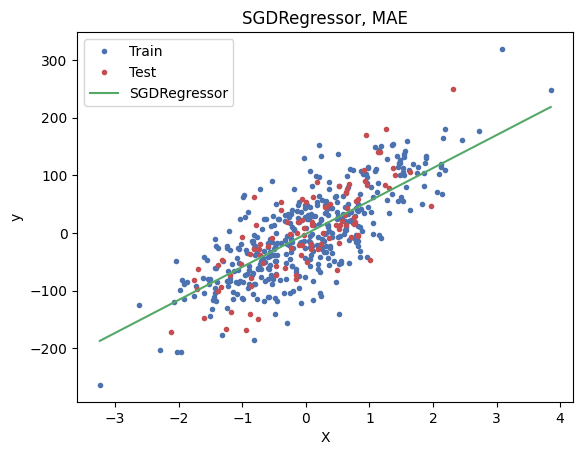

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


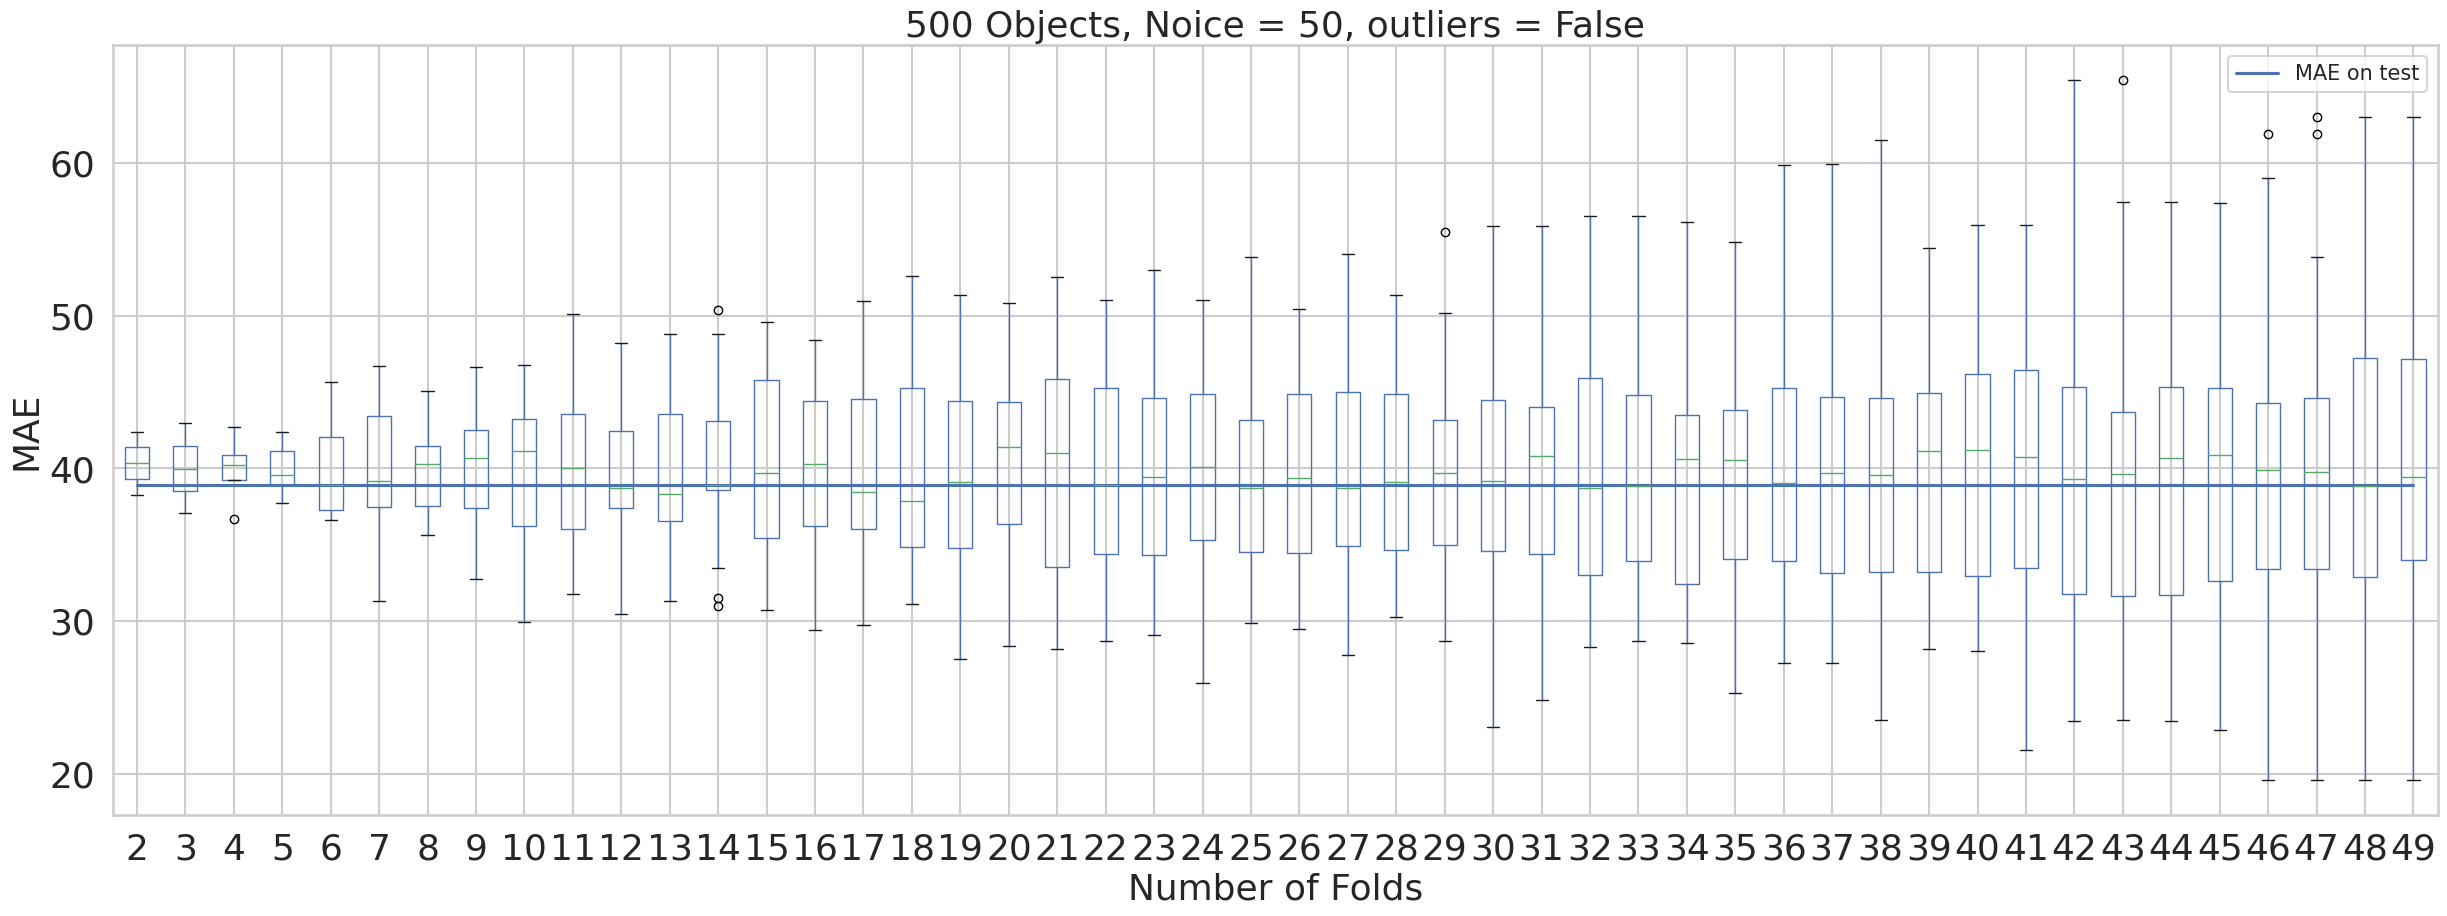

CPU times: user 53.9 s, sys: 52.7 ms, total: 54 s
Wall time: 54.1 s


In [4]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(500, 50, 50, False)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict')
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("500 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

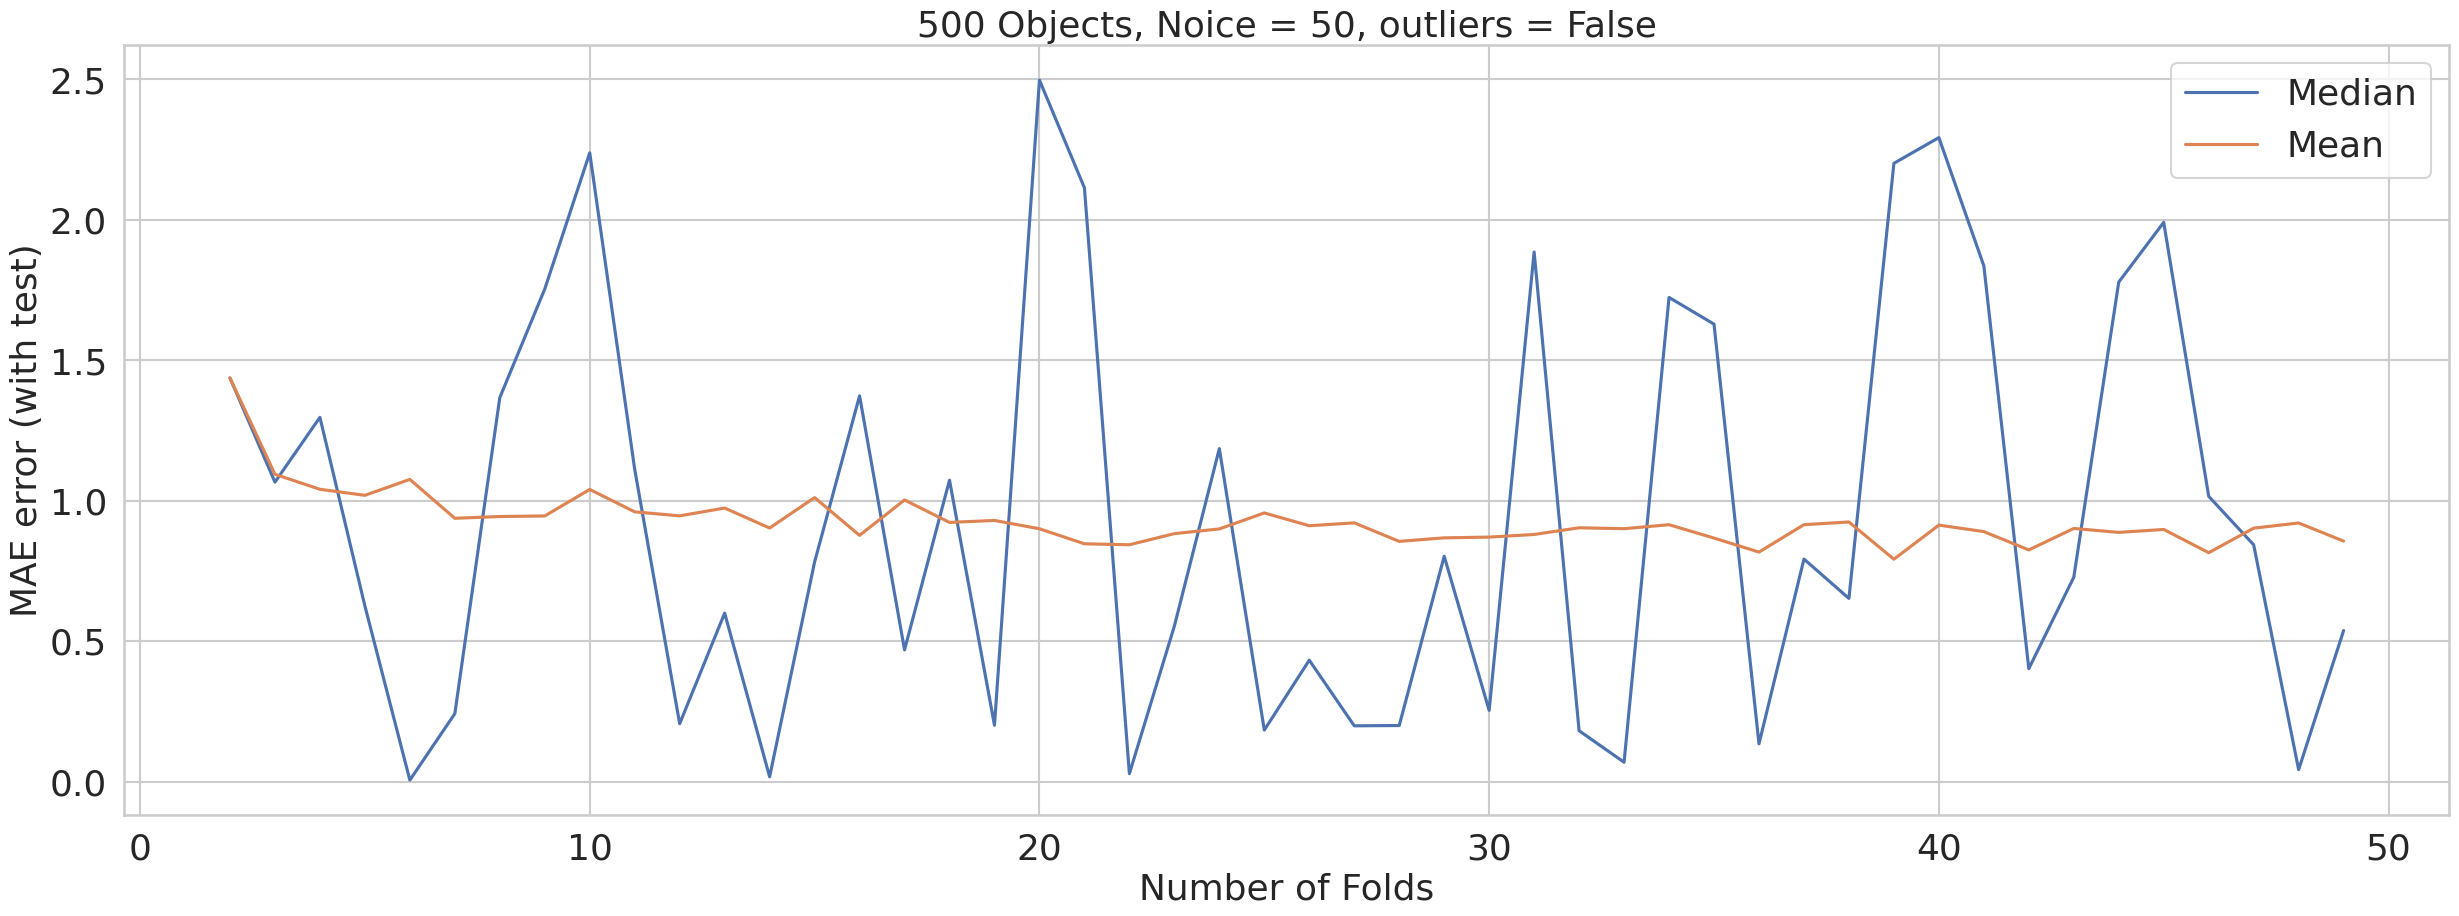

In [6]:
abs(df.median() - real_MAE).plot(label = "Median")
abs(df.mean() - real_MAE).plot(label = "Mean")
plt.title("500 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MAE error (with test)")
plt.legend()
plt.show()

Интересно, но факт - считать среднее по фолдам оказывается надёжнее, нежели чем брать медианы - этот скор сильно стабильнее и уже к числу фолдов порядка 6-7 схолится к ошибке, которая потом практически не меняется.  
Попробуем увеличить число объектов

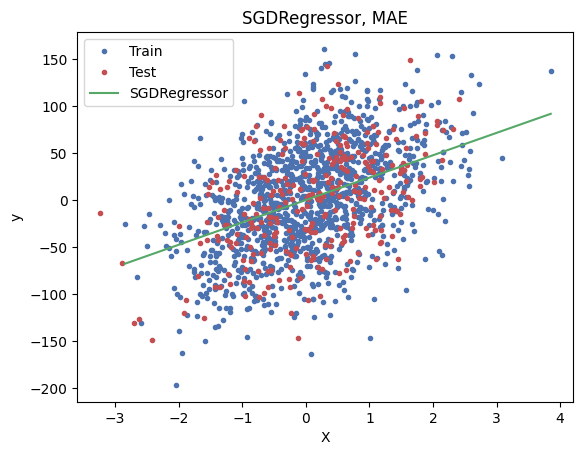

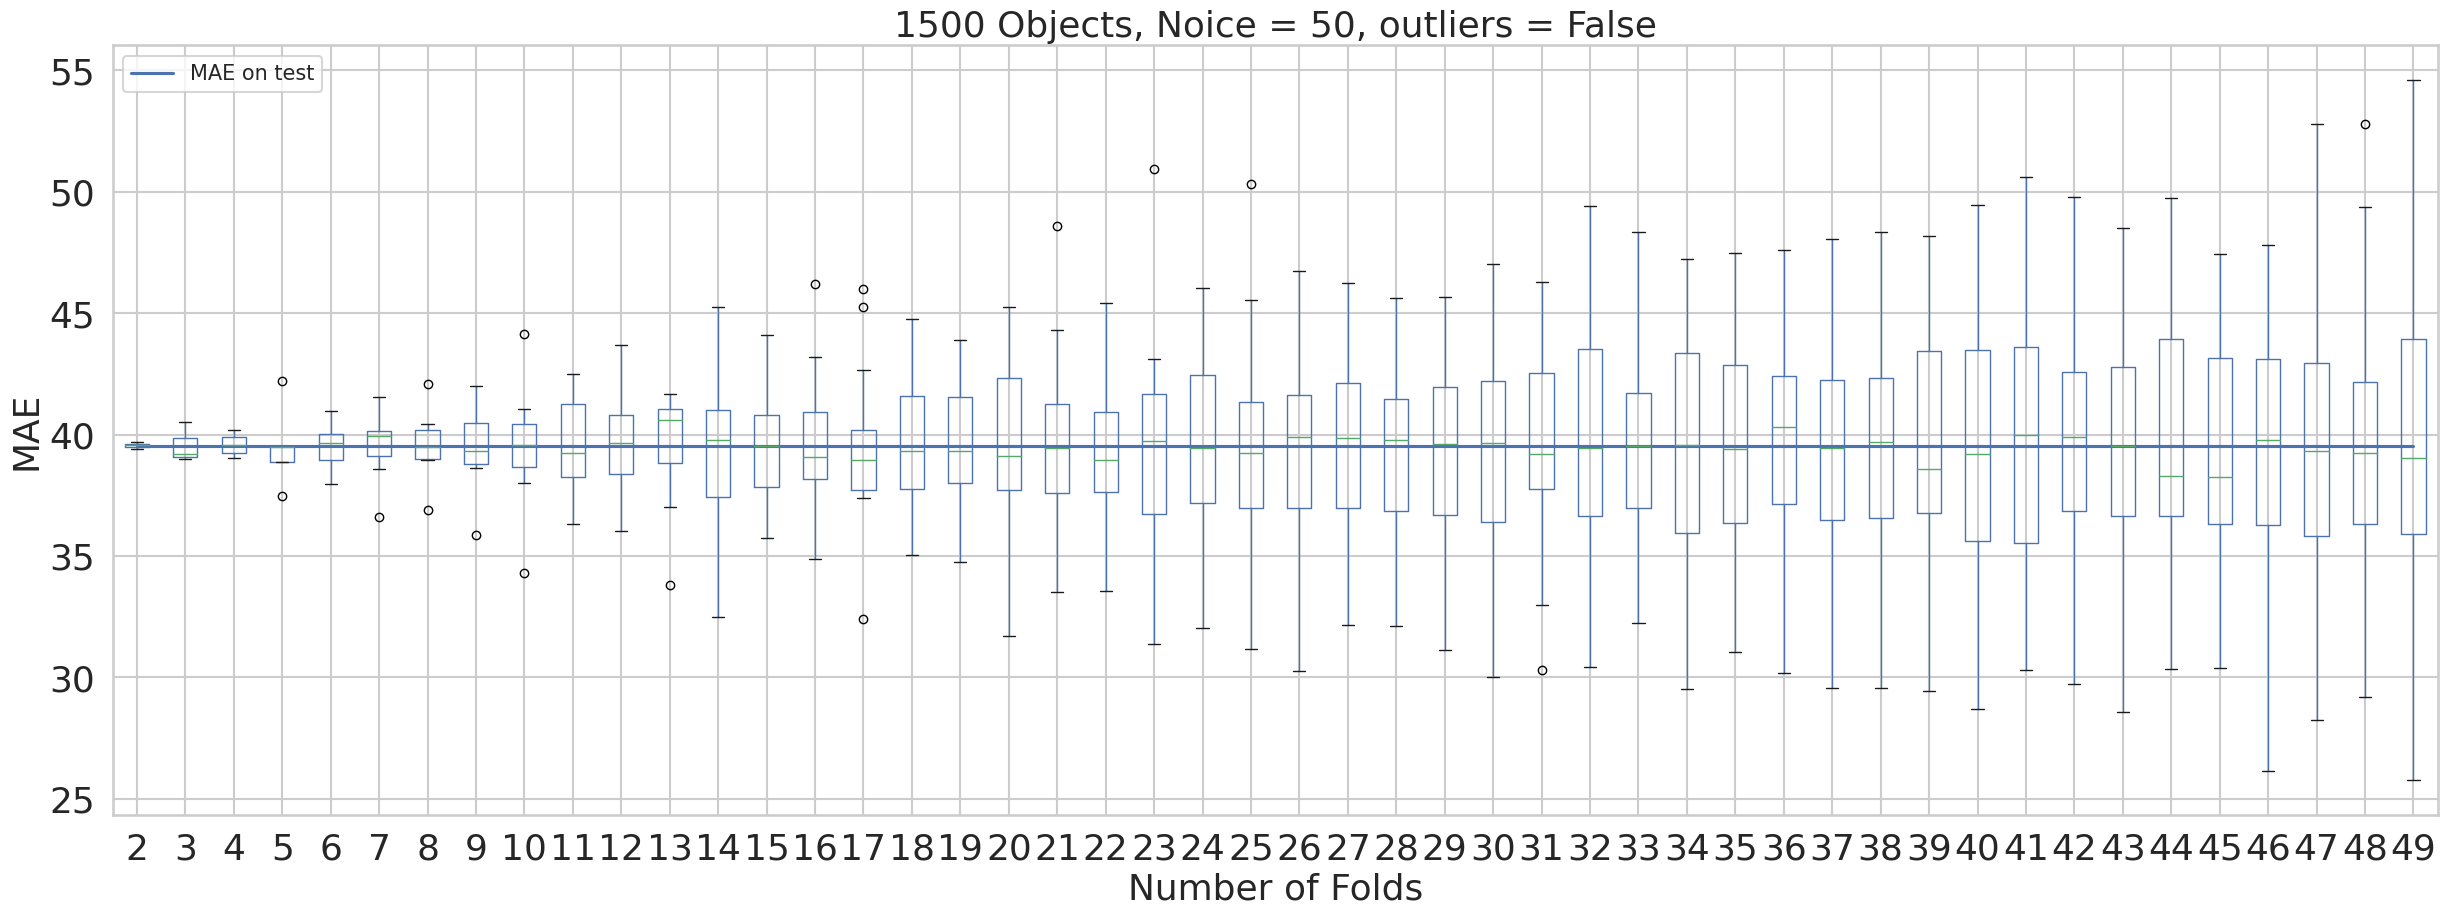

CPU times: user 36.6 s, sys: 36 ms, total: 36.7 s
Wall time: 36.7 s


In [7]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(1500, 50, 50, False)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict')
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("1500 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

Ситуация похожа. Наращивание числа фолдов не увеличивает качество валидации, а лишь увеличивает дисперсию скора.  
Поработаем теперь с яаныи

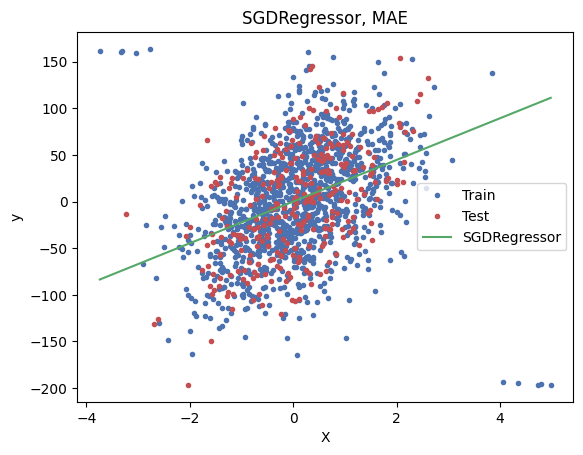

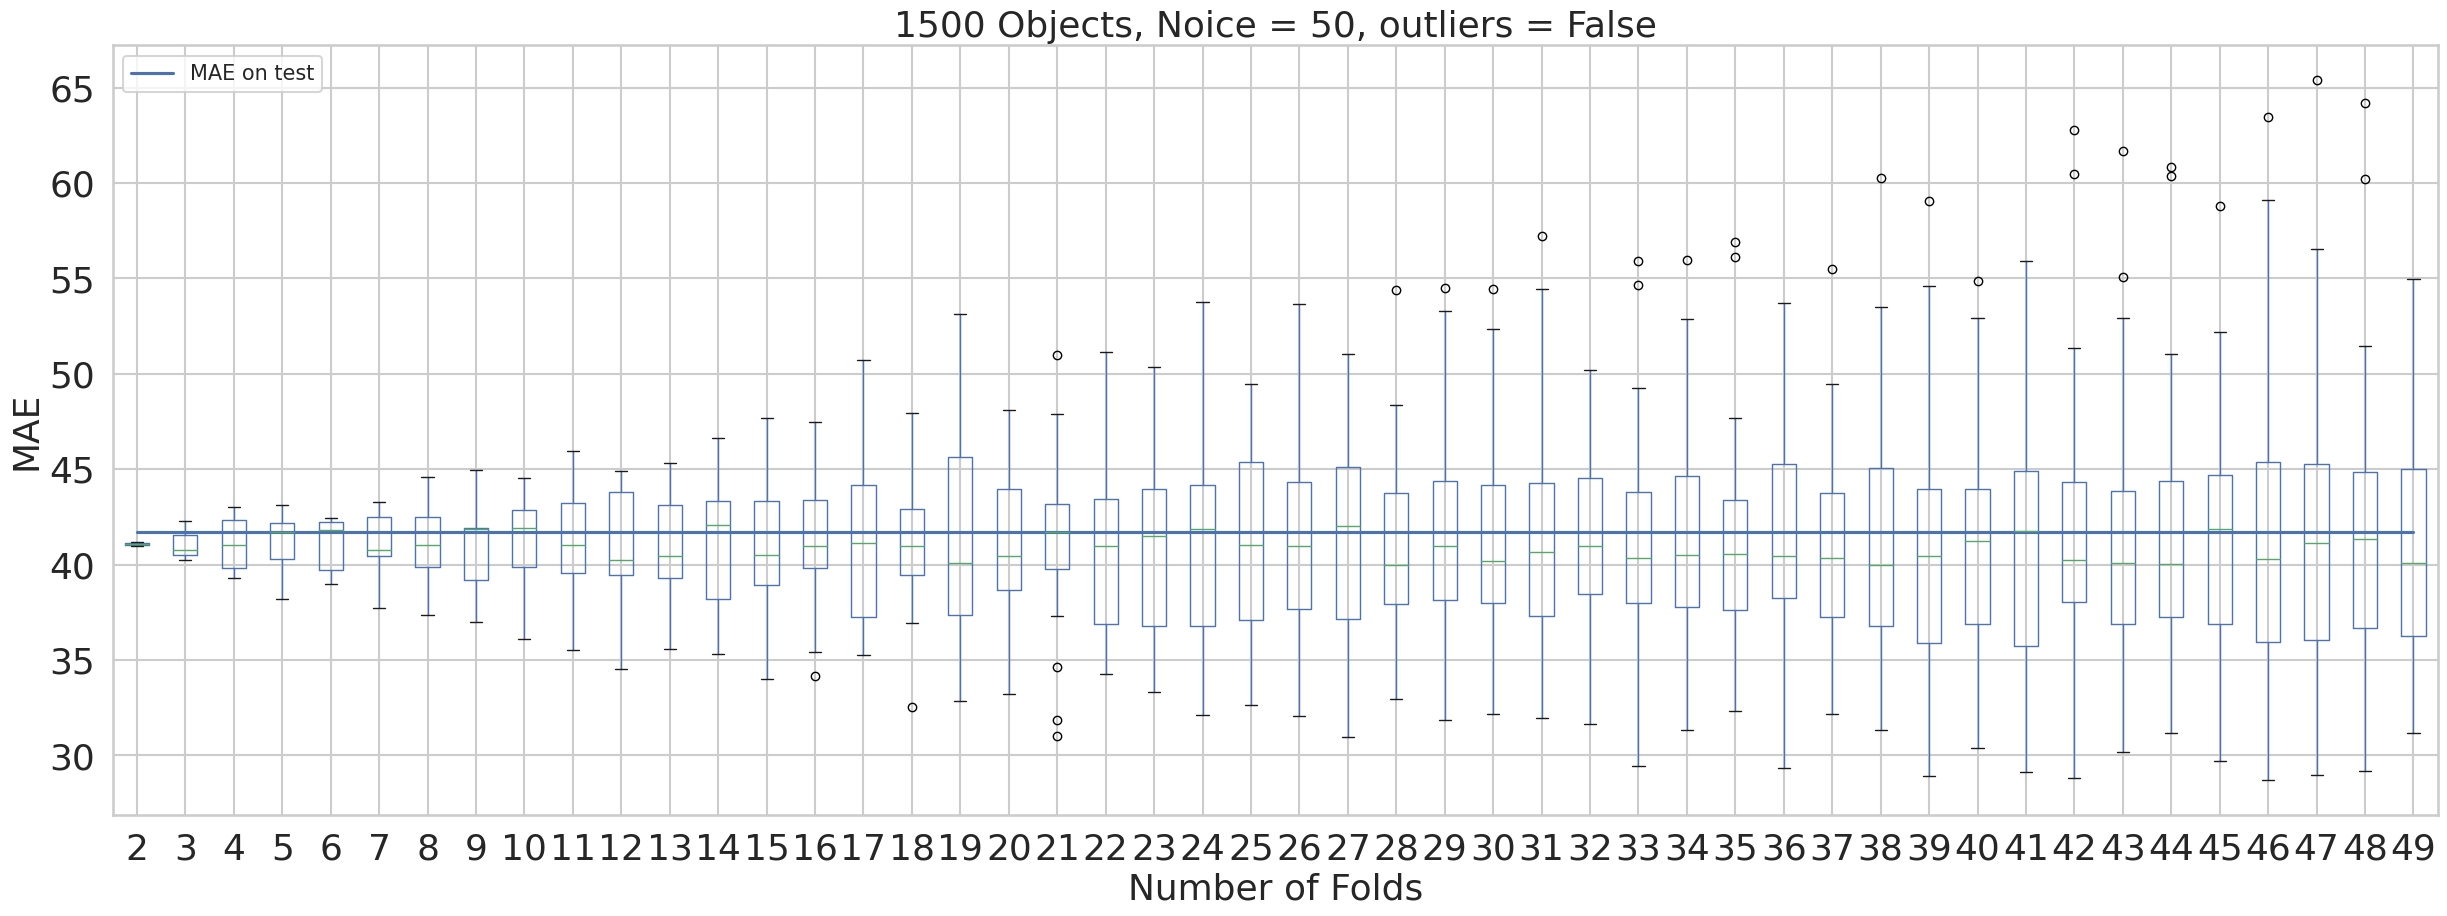

CPU times: user 36.5 s, sys: 23 ms, total: 36.5 s
Wall time: 36.6 s


In [10]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(1500, 50, 50, True, 10)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict')
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("1500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

Видим, что наличие выбросов сильно мешает жизни - наиная с 18-ти фолдов они дают нам и выбросы в скорах, постепено увеличивая дисперсию до значений, которые сильно больше относительно предыдущего примера.  
 А если выбросов будет совсем много?

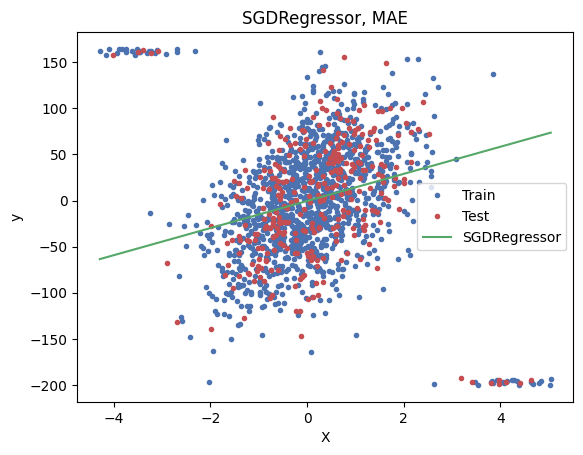

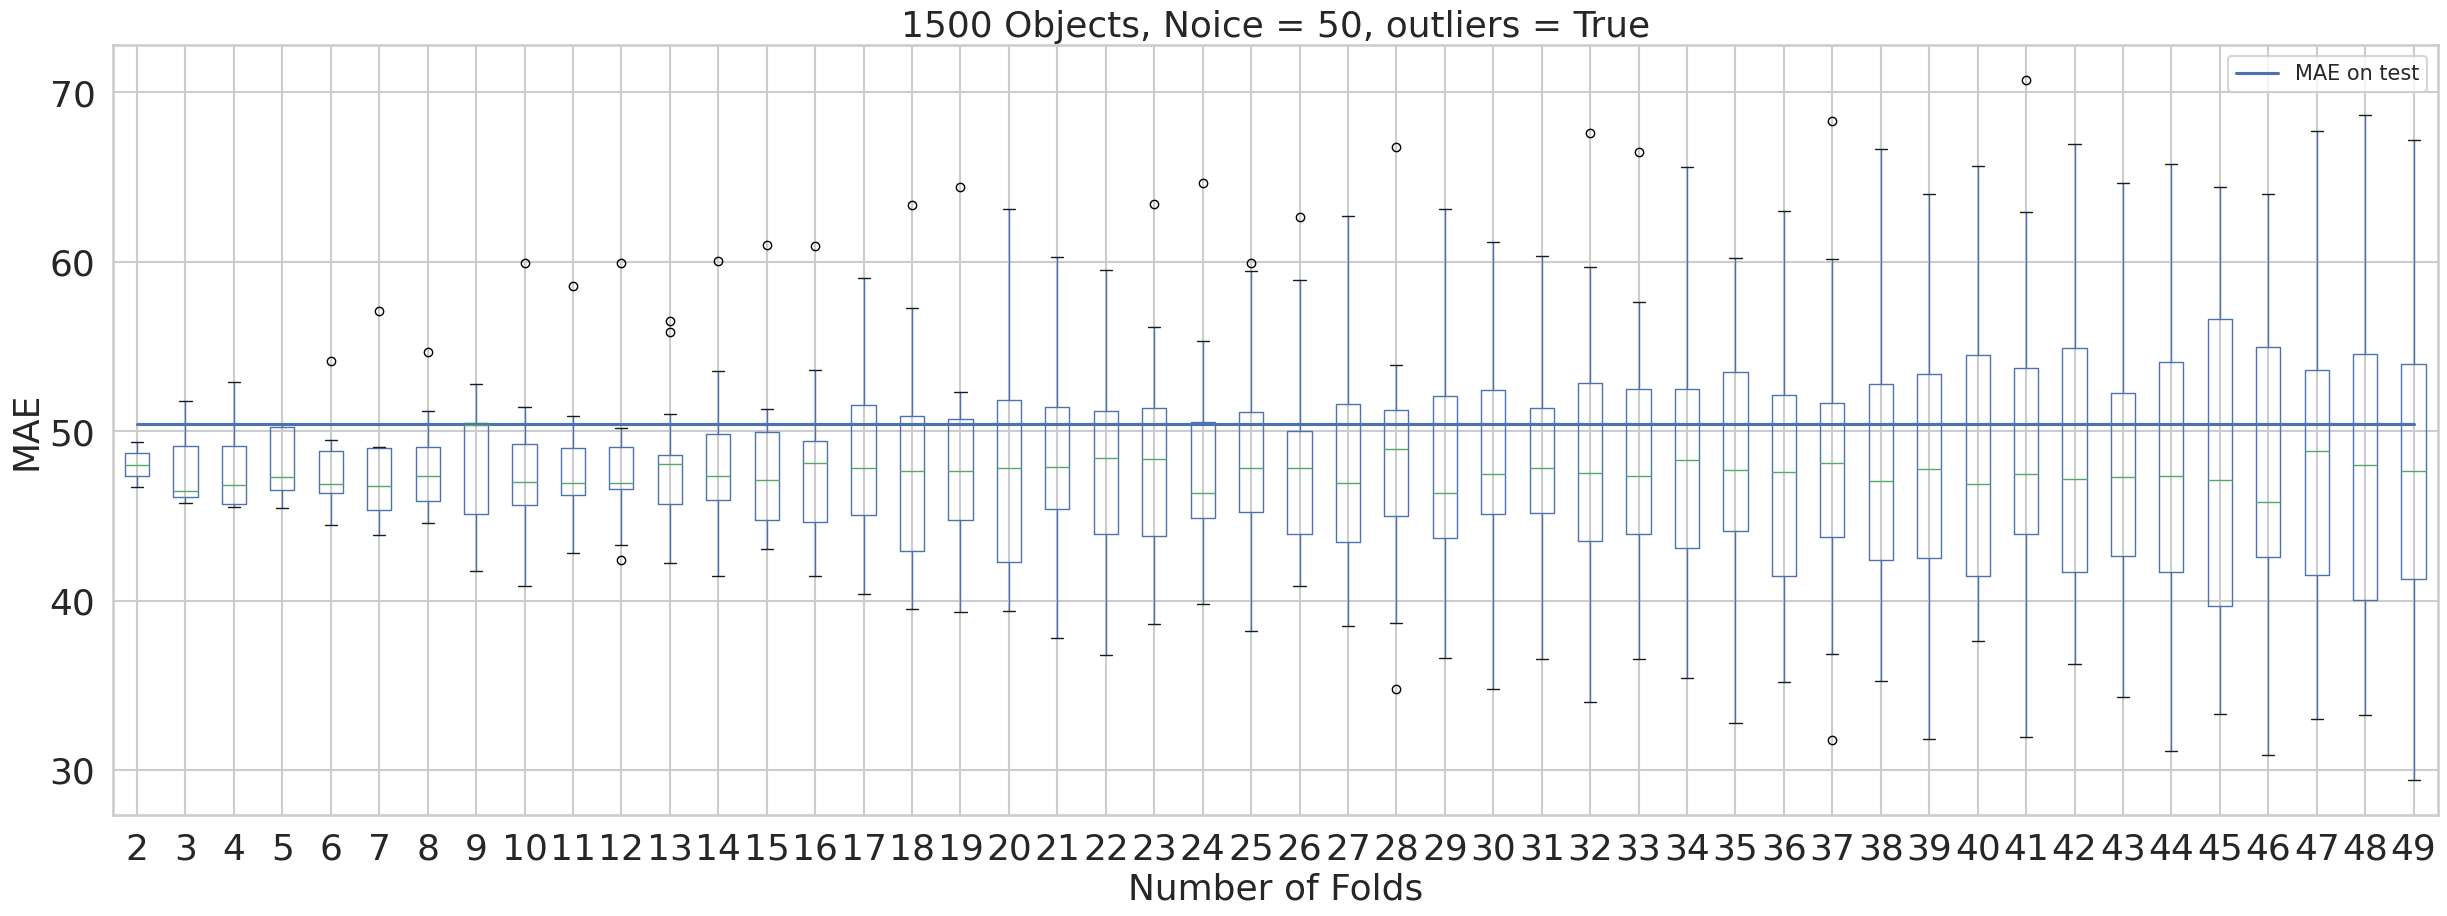

CPU times: user 32.2 s, sys: 22 ms, total: 32.2 s
Wall time: 32.2 s


In [12]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(1500, 50, 50, True, 60)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict')
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("1500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

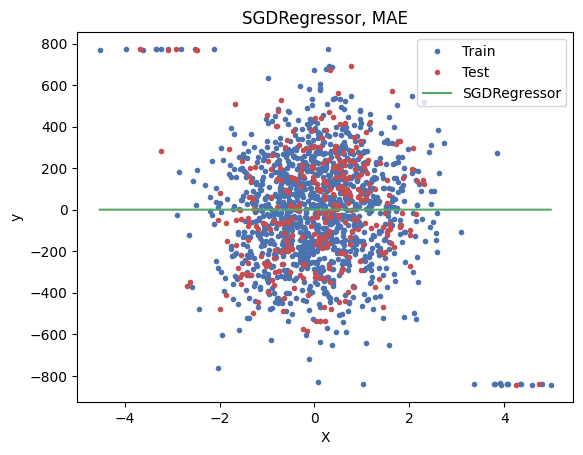

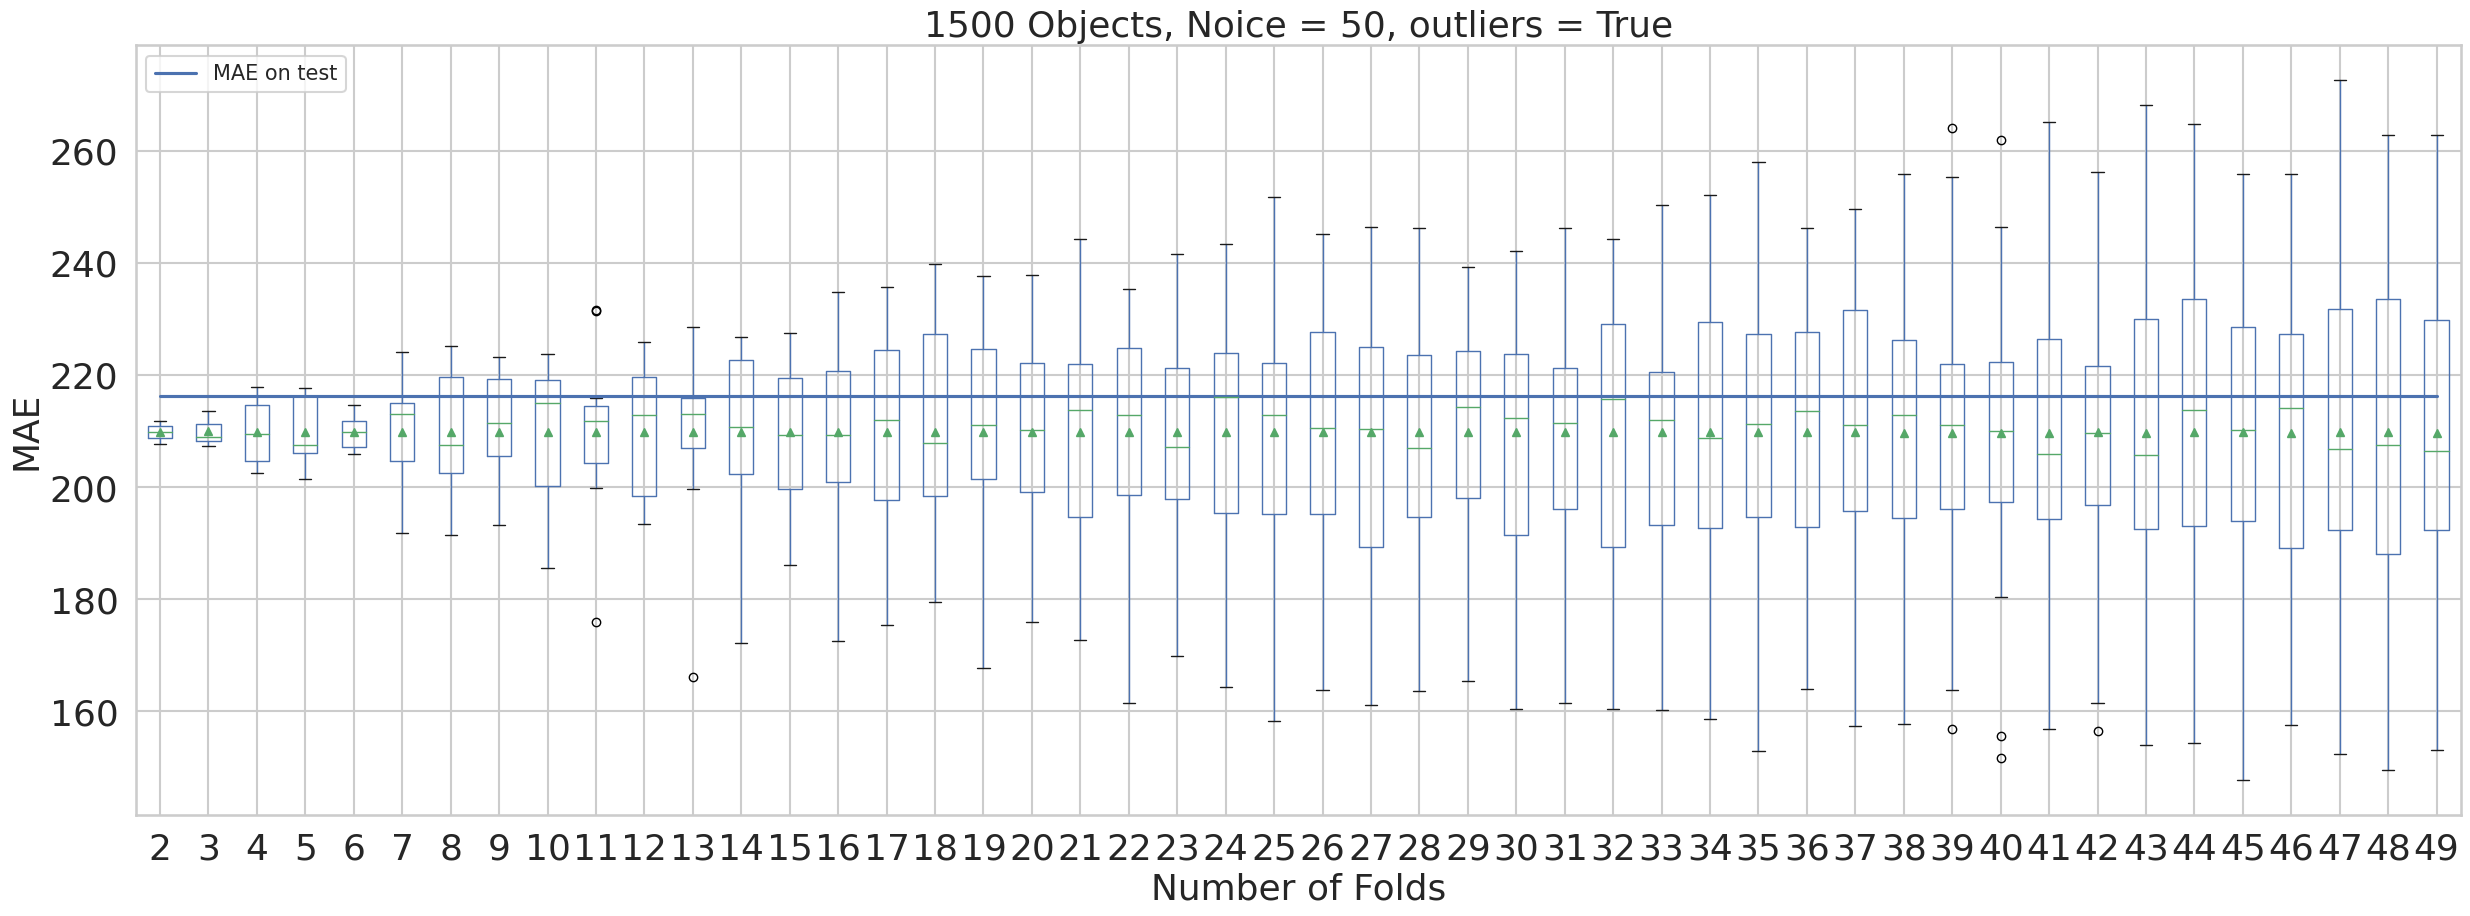

CPU times: user 3.73 s, sys: 26 ms, total: 3.75 s
Wall time: 3.76 s


In [13]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(1500, 250, 50, True, 30)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("1500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

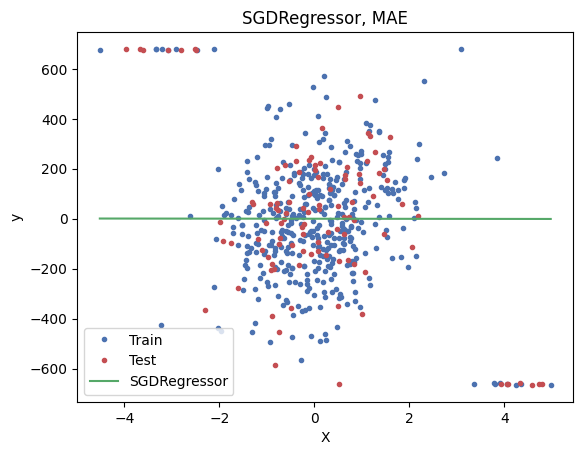

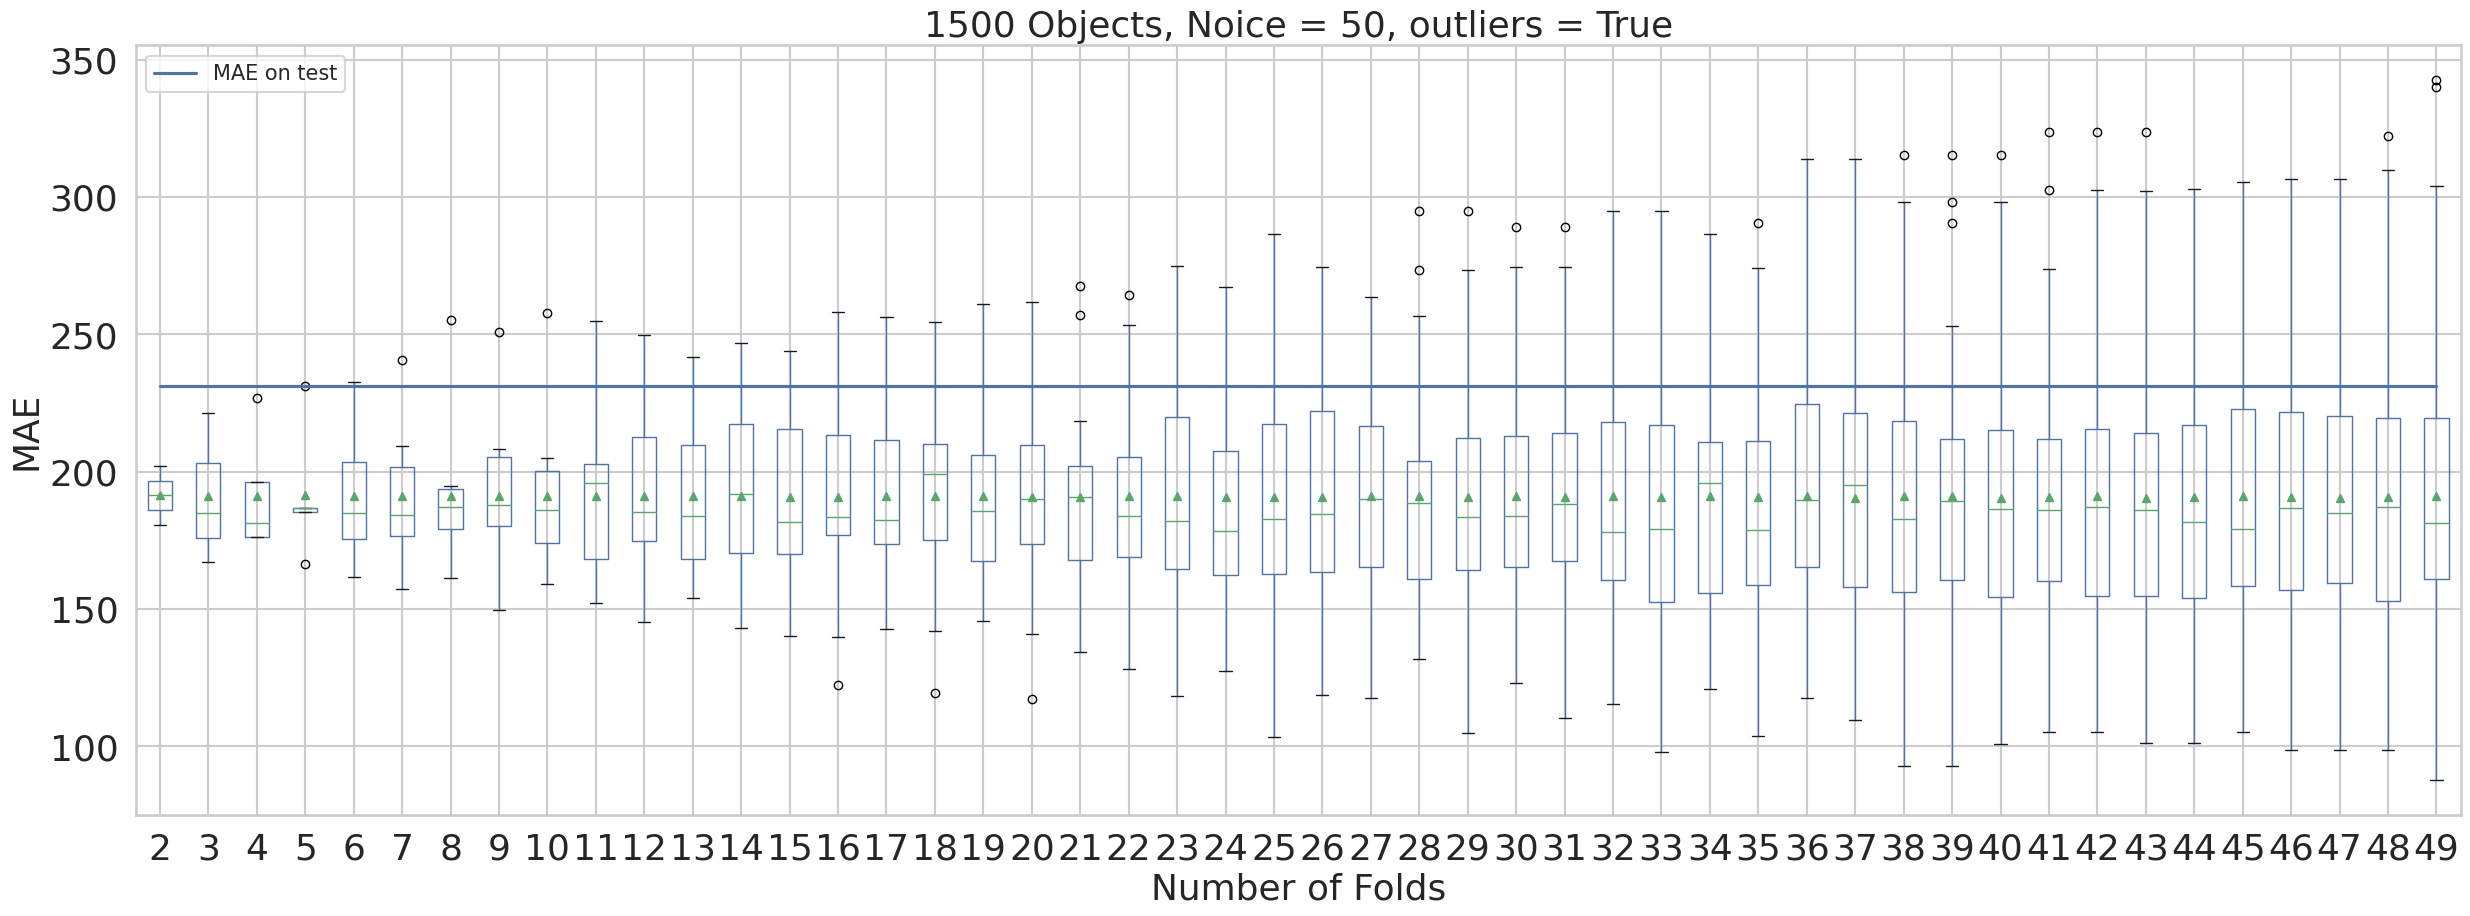

CPU times: user 3.24 s, sys: 13 ms, total: 3.25 s
Wall time: 3.26 s


In [14]:
%%time 
real_MAE, for_plot_mini, dict_folds = make_exp_lr(500, 200, 50, True, 30)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MAE, real_MAE]
plt.plot(x_coordinates, y_coordinates, label="MAE on test")
plt.legend(fontsize=15)
plt.title("1500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MAE")
plt.show()

Пр любом раскладе - большом числе выбросов, большом шуме, большом и небольшом числе объектов, видим, что наилучшее качество всё равно достигается на <= 10 фолдов. Кроме того, дальше начинает сильно расти дисперсия, причём чем больше выбросов, тем она сильнее.

## MSE


P.S. Тут будем рисовать боксплоты с медианой и средним, но ориентироваться конечно будем на среднее

In [25]:
def make_exp_lr(samples, noice, n_folds_max, outl = False, n = 4):
  X, y = make_regression(n_samples=samples, n_features=1, noise=noice, random_state = 42)
  
  if outl:
    rng = np.random.RandomState(0)
    
    X_outliers = rng.normal(0, 0.5, size=(n, 1))
    y_outliers = rng.normal(0, 2.0, size=n)
    X_outliers[:int(n/2), :] += X.max() + X.mean() / (noice/n)
    X_outliers[int(n/2):, :] += X.min() - X.mean() / (noice/n)
    y_outliers[:int(n/2)] += y.min() - y.mean() / (noice/n)
    y_outliers[int(n/2):] += y.max() + y.mean() / (noice/n)
    X = np.vstack((X, X_outliers))
    y = np.concatenate((y, y_outliers))


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  plt.style.use('default')
  plt.plot(X_train, y_train, 'b.', label = "Train")
  plt.plot(X_test, y_test, 'r.', label = "Test")

  # Fit the huber regressor over \ series of epsilon values.
  colors = ['r-', 'b-', 'y-', 'm-']

  x = np.linspace(X_train.min(), X_train.max(), 7)
  epsilon_values = [1.35, 1.5, 1.75, 1.9]

  # Fit a ridge regressor to compare it to huber regressor.
  lin = LinearRegression()
  lin.fit(X, y)
  coef_lin = lin.coef_
  coef_ = lin.coef_ * x + lin.intercept_
  plt.plot(x, coef_, 'g-', label="LinearRegression")

  plt.title("LinearRegression, MSE")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend(loc=0)
  plt.show()


  sns.set()

  sns.set_style('whitegrid')
  sns.set_context('talk')
  params = {'legend.fontsize': 'x-large',
            'figure.figsize': (30, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}

  plt.rcParams.update(params)
  lr = LinearRegression().fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  real_qual_MSE = mean_squared_error(y_test, y_pred)

  

  data_res = []
  data_big_res = {}

  for i in range(2, n_folds_max):  
    kf = KFold(n_splits=i, shuffle=True, random_state = 42)
    scores_mse = []
    lr_mse = LinearRegression()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lr_mse.fit(X_train, y_train)
        pred_mse = lr_mse.predict(X_test)
        scores_mse.append(mean_squared_error(y_test, pred_mse))
        
    
    data_big_res[i] = scores_mse
    scores_mse = np.array(scores_mse)
    data_res.append({'mean': scores_mse.mean(),  'std': scores_mse.std()})


  results_pd = pd.DataFrame(data = data_res, columns = ['mean','std'])
  results_pd['n_folds'] = [i for i  in range(2, n_folds_max)]

  #print("Here is some information about KFold")
  return real_qual_MSE, results_pd, data_big_res

Для начала посмотрим как будет себя вести ошибка на данных с умеренным шумом, но без выбросов:


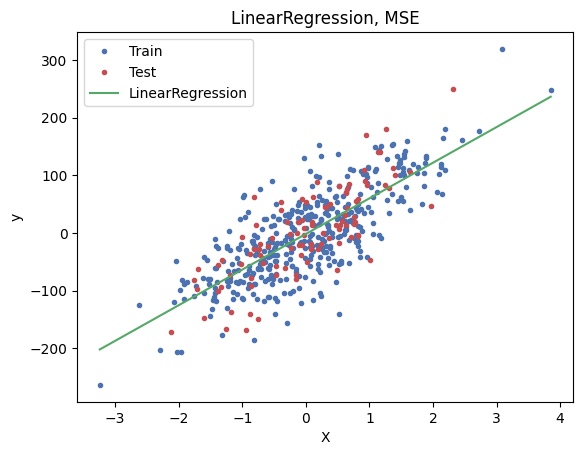

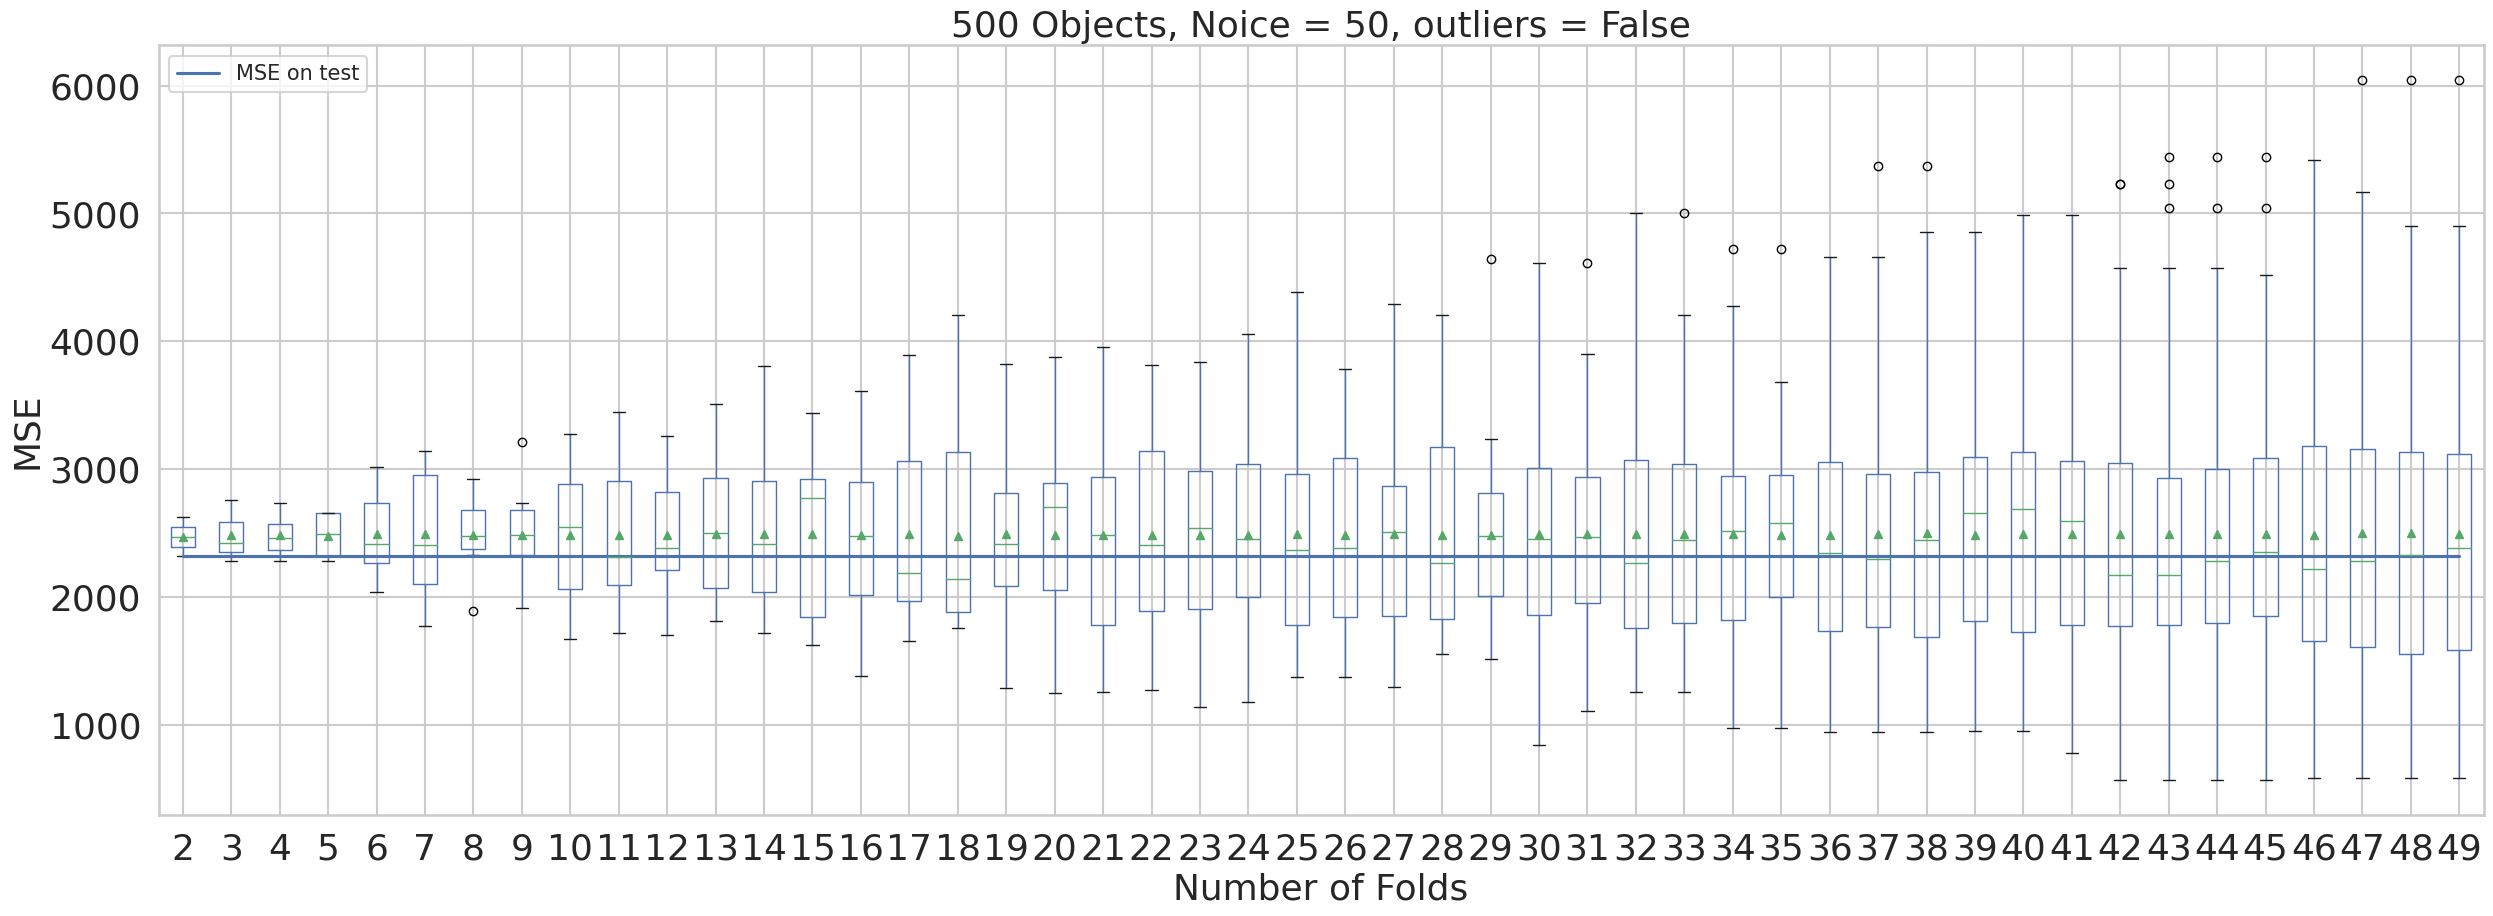

CPU times: user 2.42 s, sys: 29 ms, total: 2.44 s
Wall time: 2.45 s


In [18]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(500, 50, 50, False)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("500 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

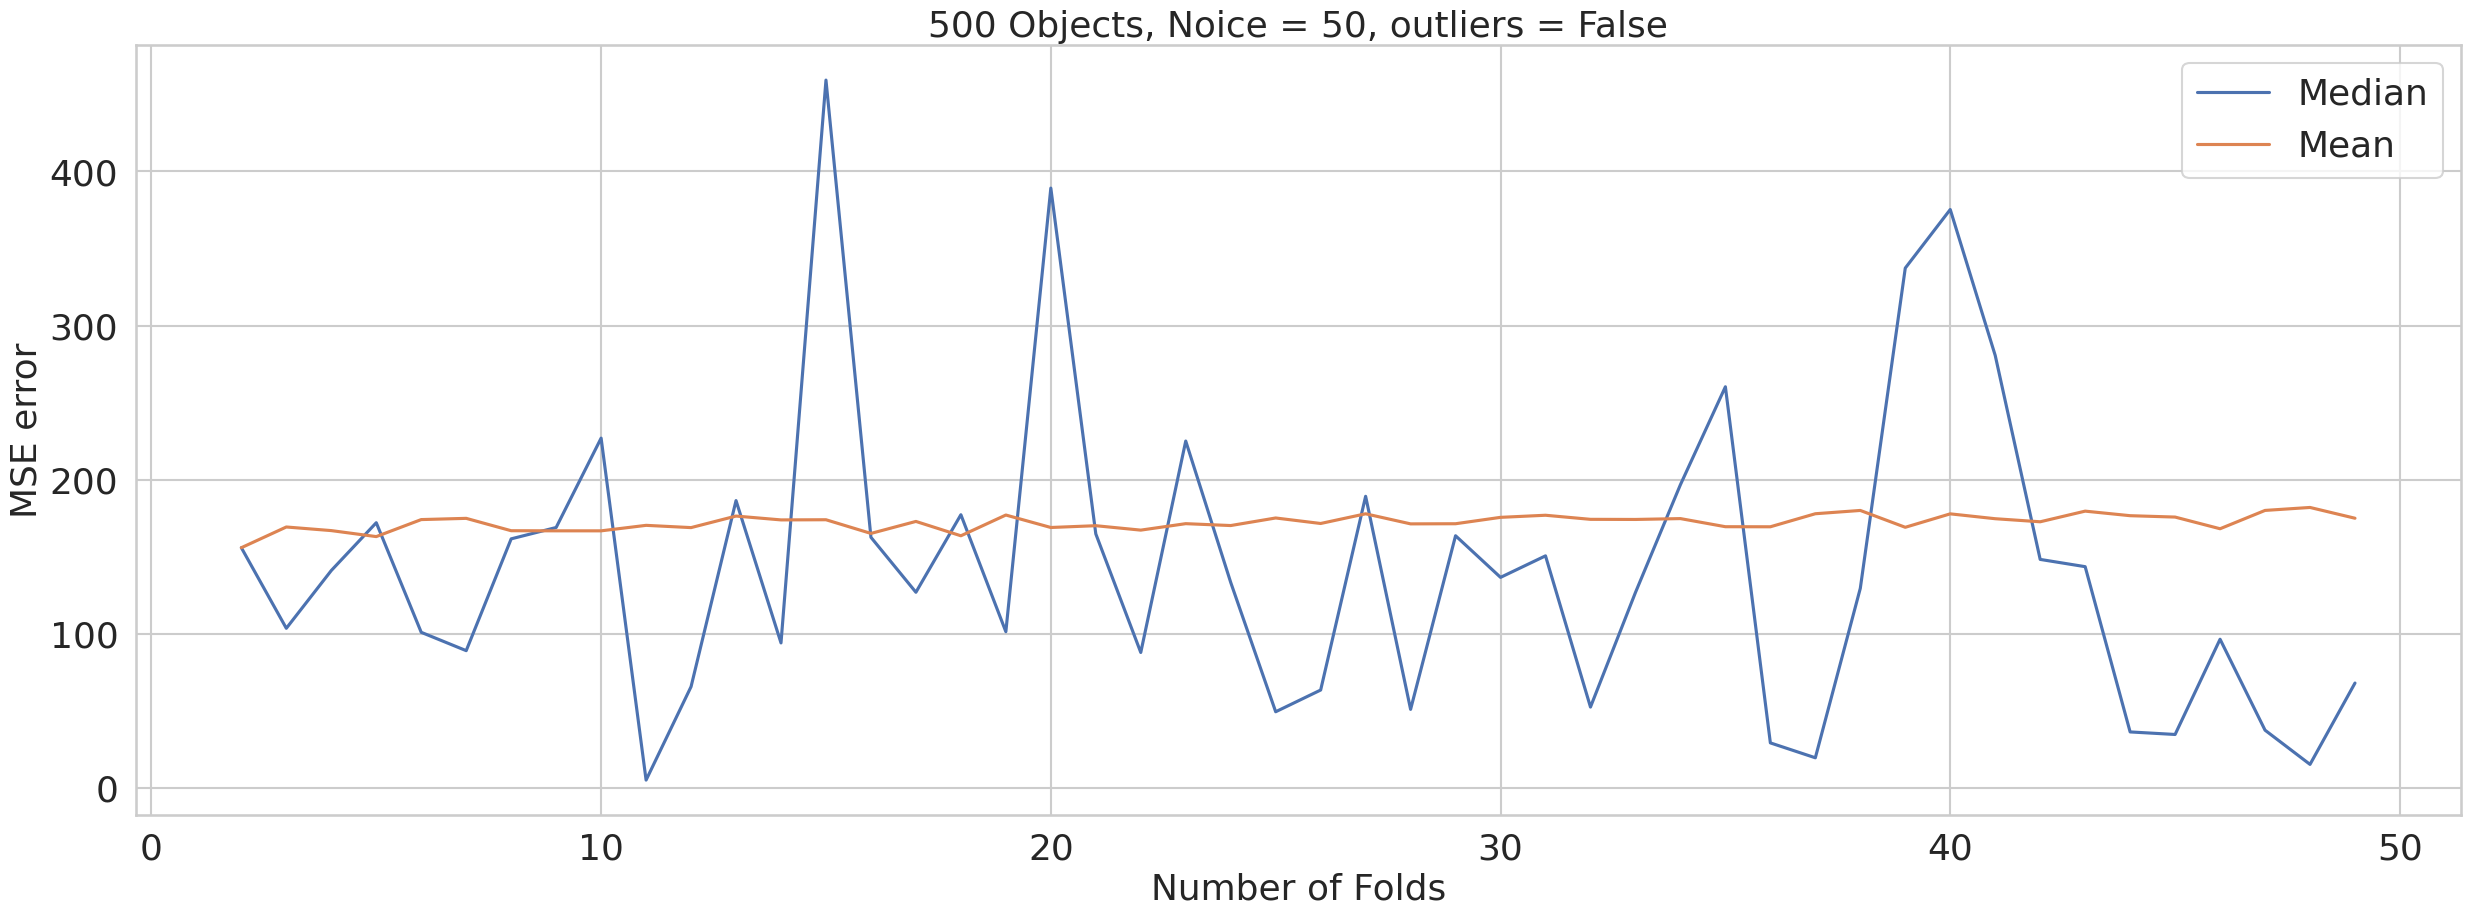

In [19]:

abs(df.median() - real_MSE).plot(label = "Median")
abs(df.mean() - real_MSE).plot(label = "Mean")
plt.title("500 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MSE error")
plt.legend()
plt.show()

Видим, что среднее ведёт себя куда стабильнее медианы, что подтверждается в том числе и теоретически. Но на Boxplot видно, что при наращивании числа фолдов больше, чем 30 (на выборке 300 объектов) начинают порождаться выбросы в оценке скора

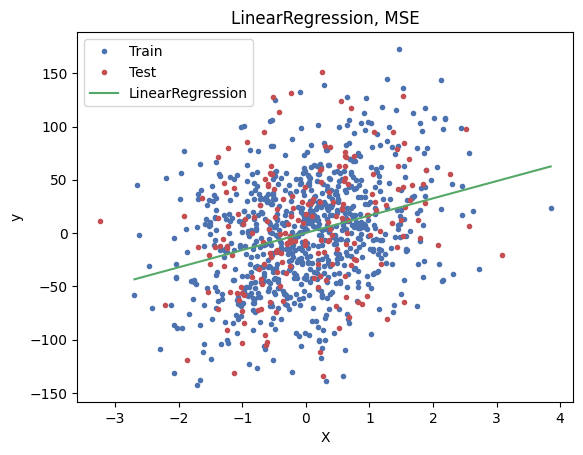

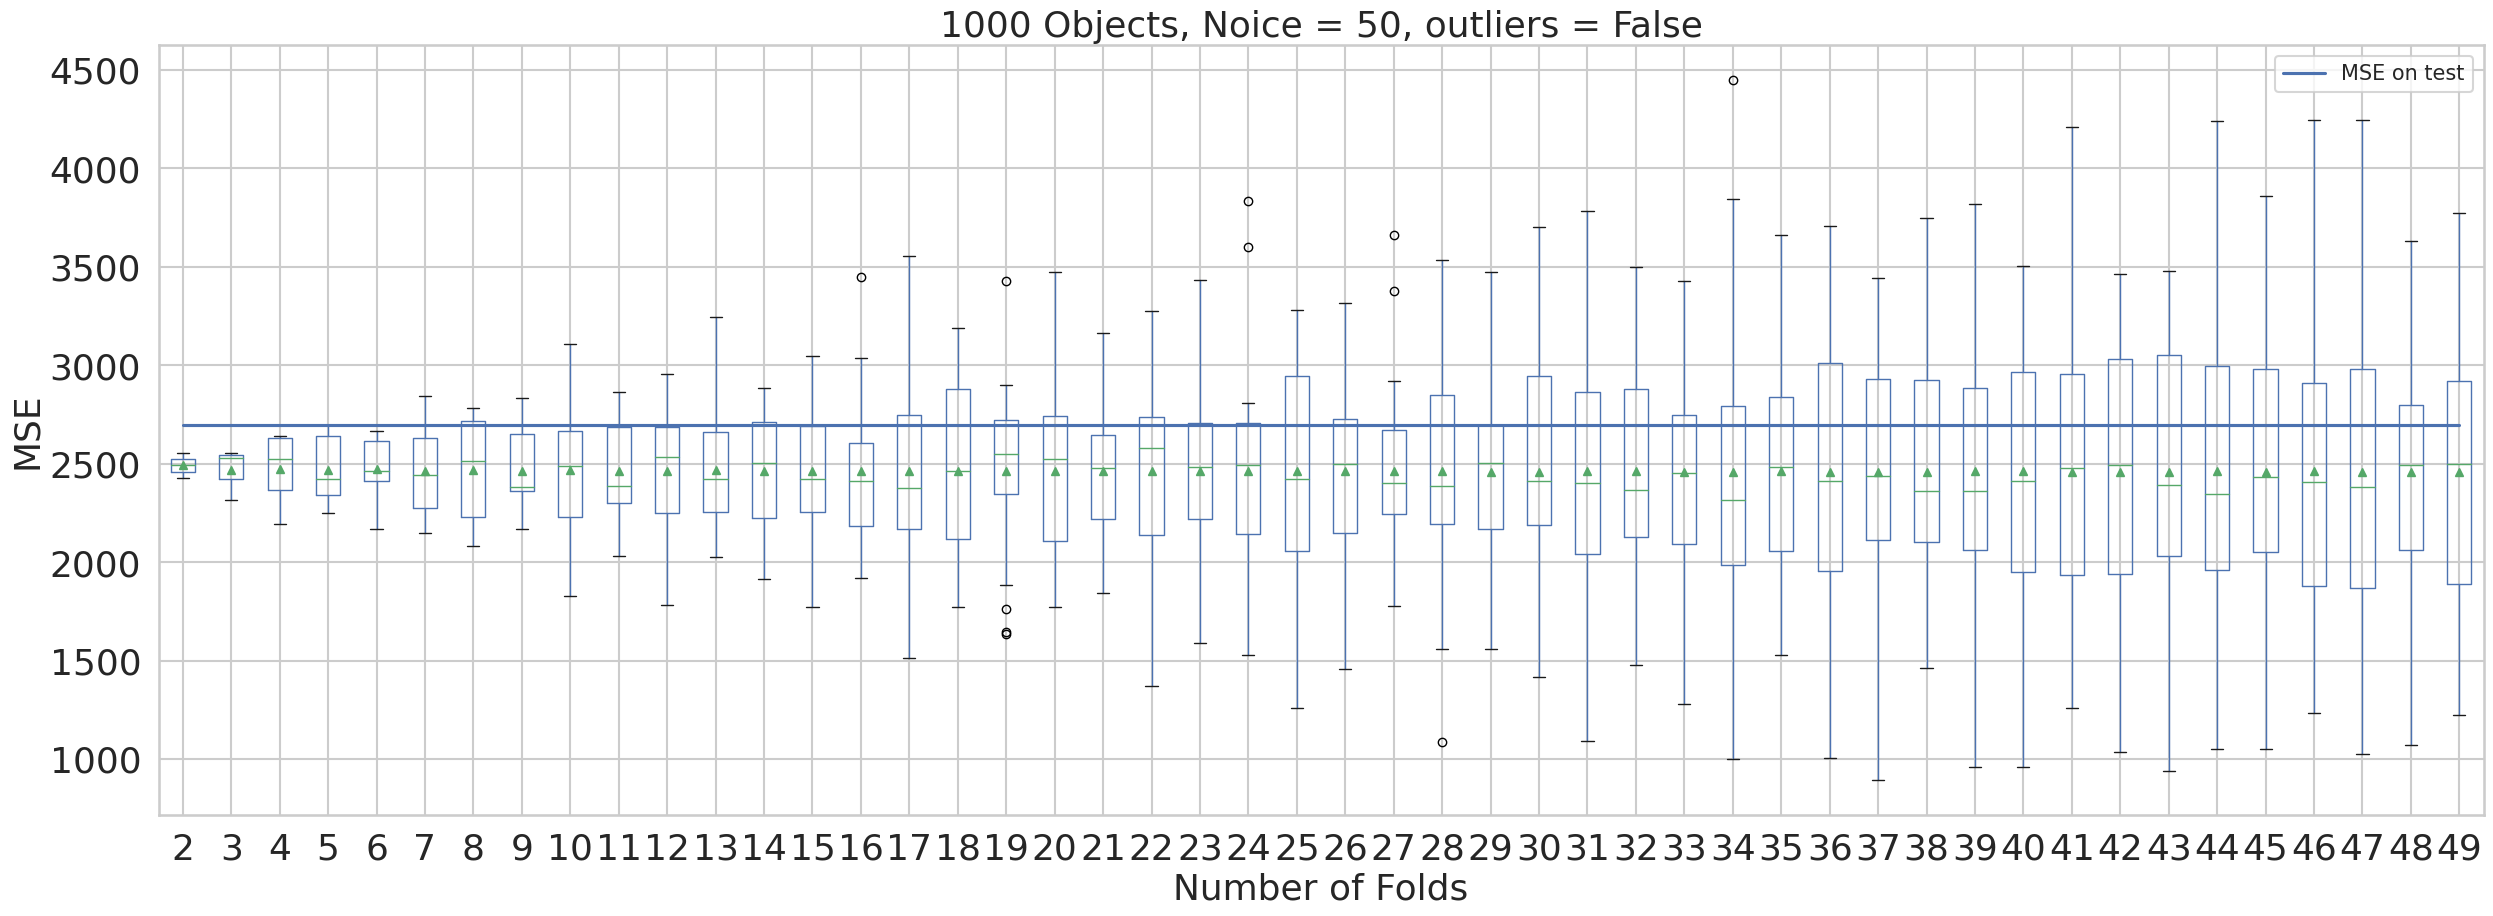

CPU times: user 2.53 s, sys: 20.9 ms, total: 2.55 s
Wall time: 2.56 s


In [22]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(1000, 50, 50, False)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("1000 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

При увеличении числа объектов число выбросов на высоких значениях начинает снижаться.   
Попробуем связать число фолдов, с которого начинаются массовые выбросы, с числом объектов в выборке. На выборке из 500 объектов они начались ~с 33 фолдов. По такой логике на выборке из 250 объектов они должны начаться раньше. проверим гипотезу.

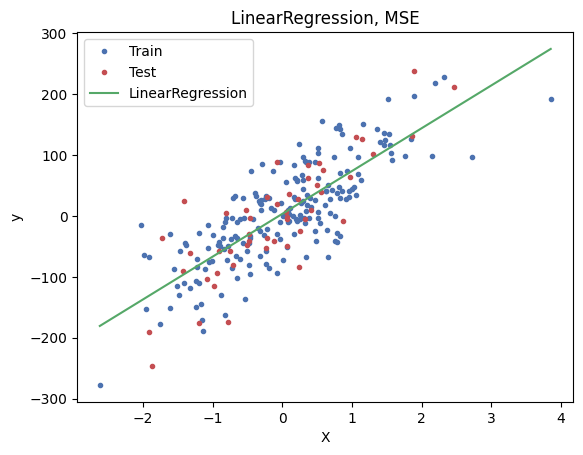

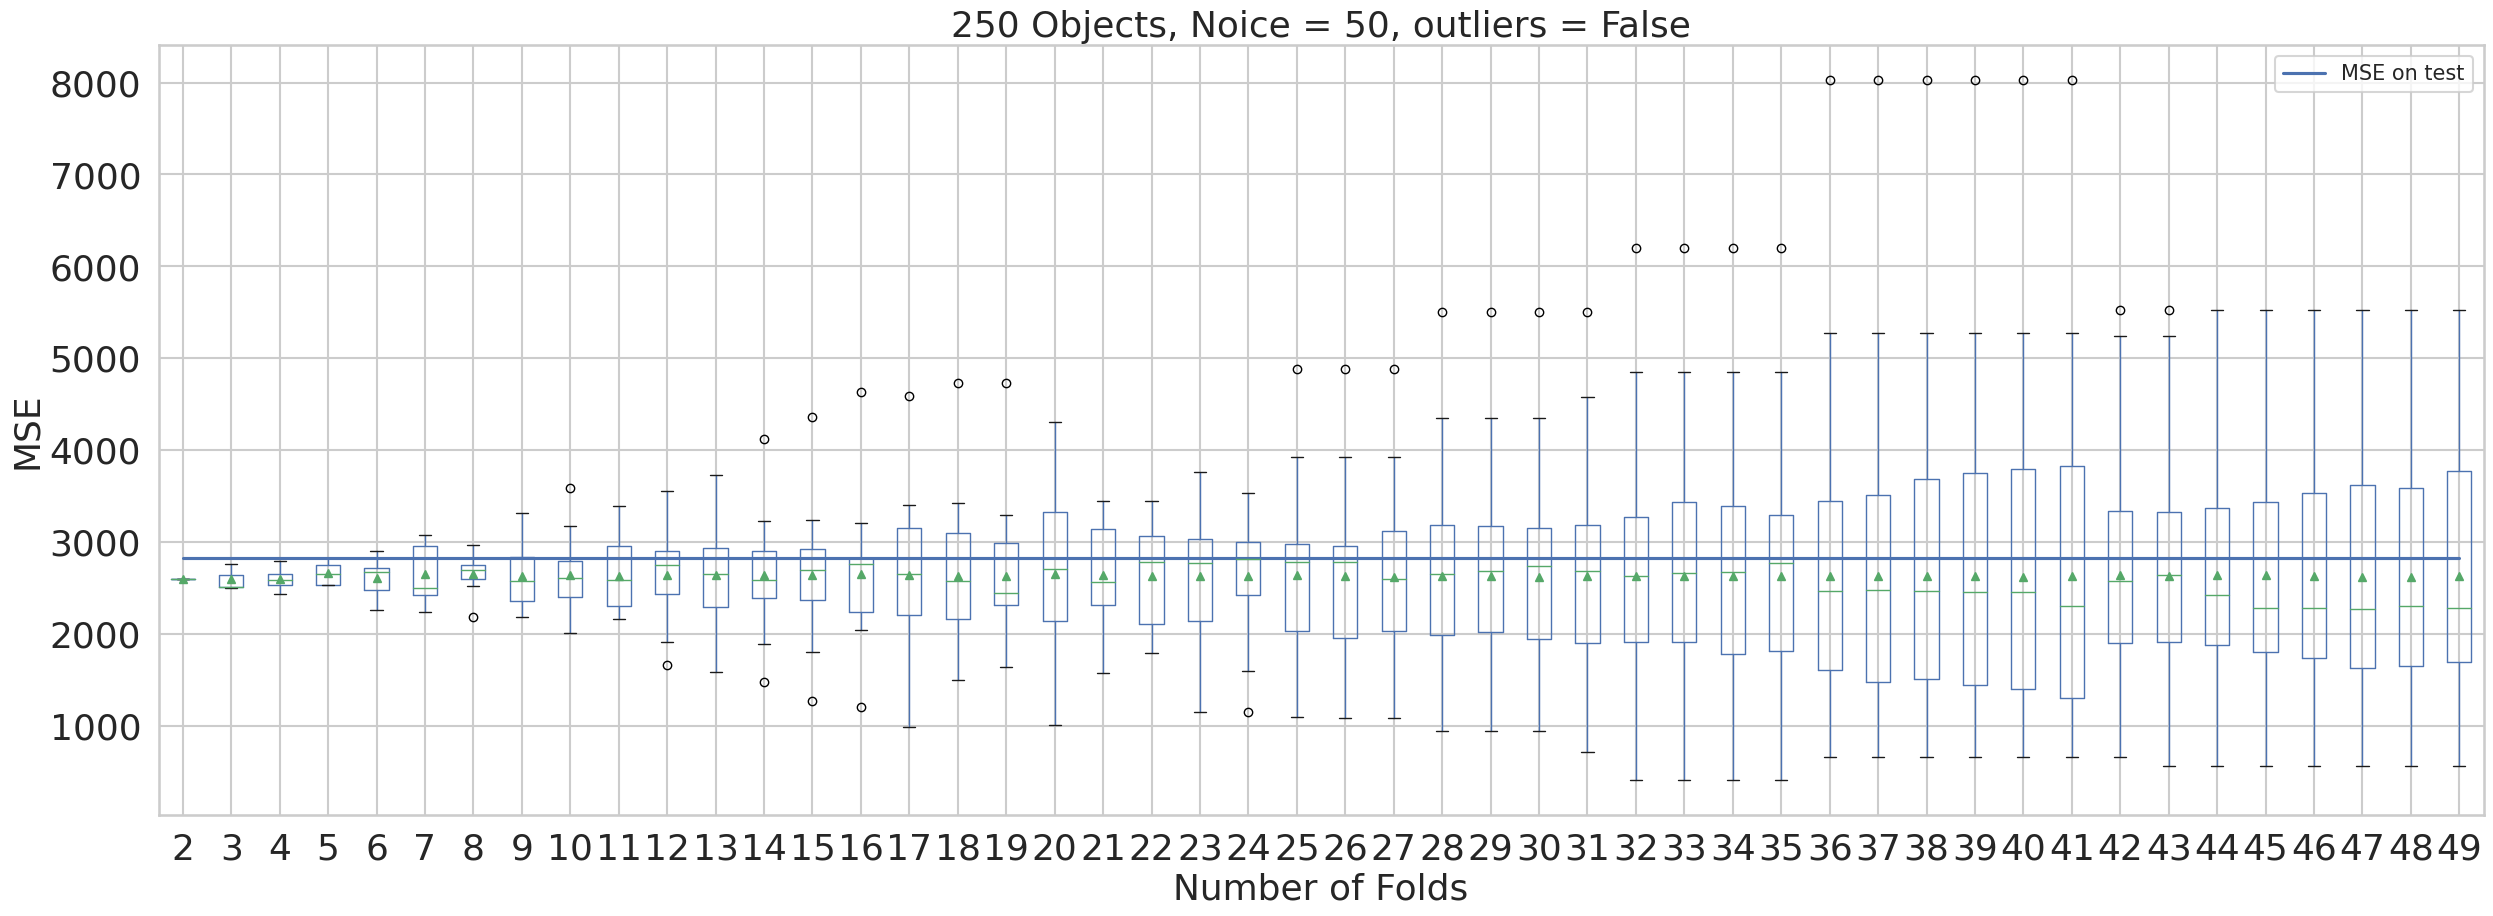

CPU times: user 2.28 s, sys: 26 ms, total: 2.31 s
Wall time: 2.29 s


In [23]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(250, 50, 50, False)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("250 Objects, Noice = 50, outliers = False")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

Видим, что выбросы на небольших значениях числа фолдов есть, но они достаточно точеченые.  
Попробуем теперь добавлять явные выбросы


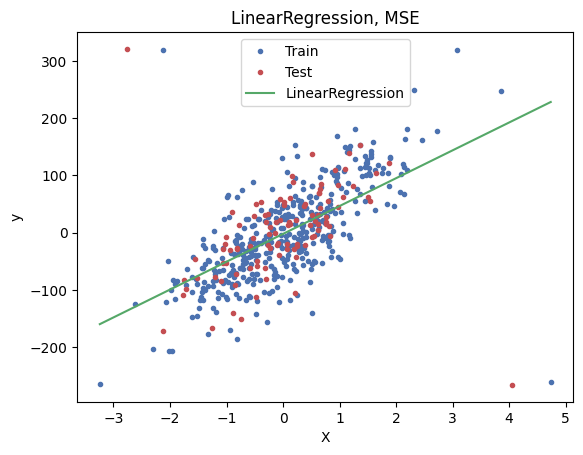

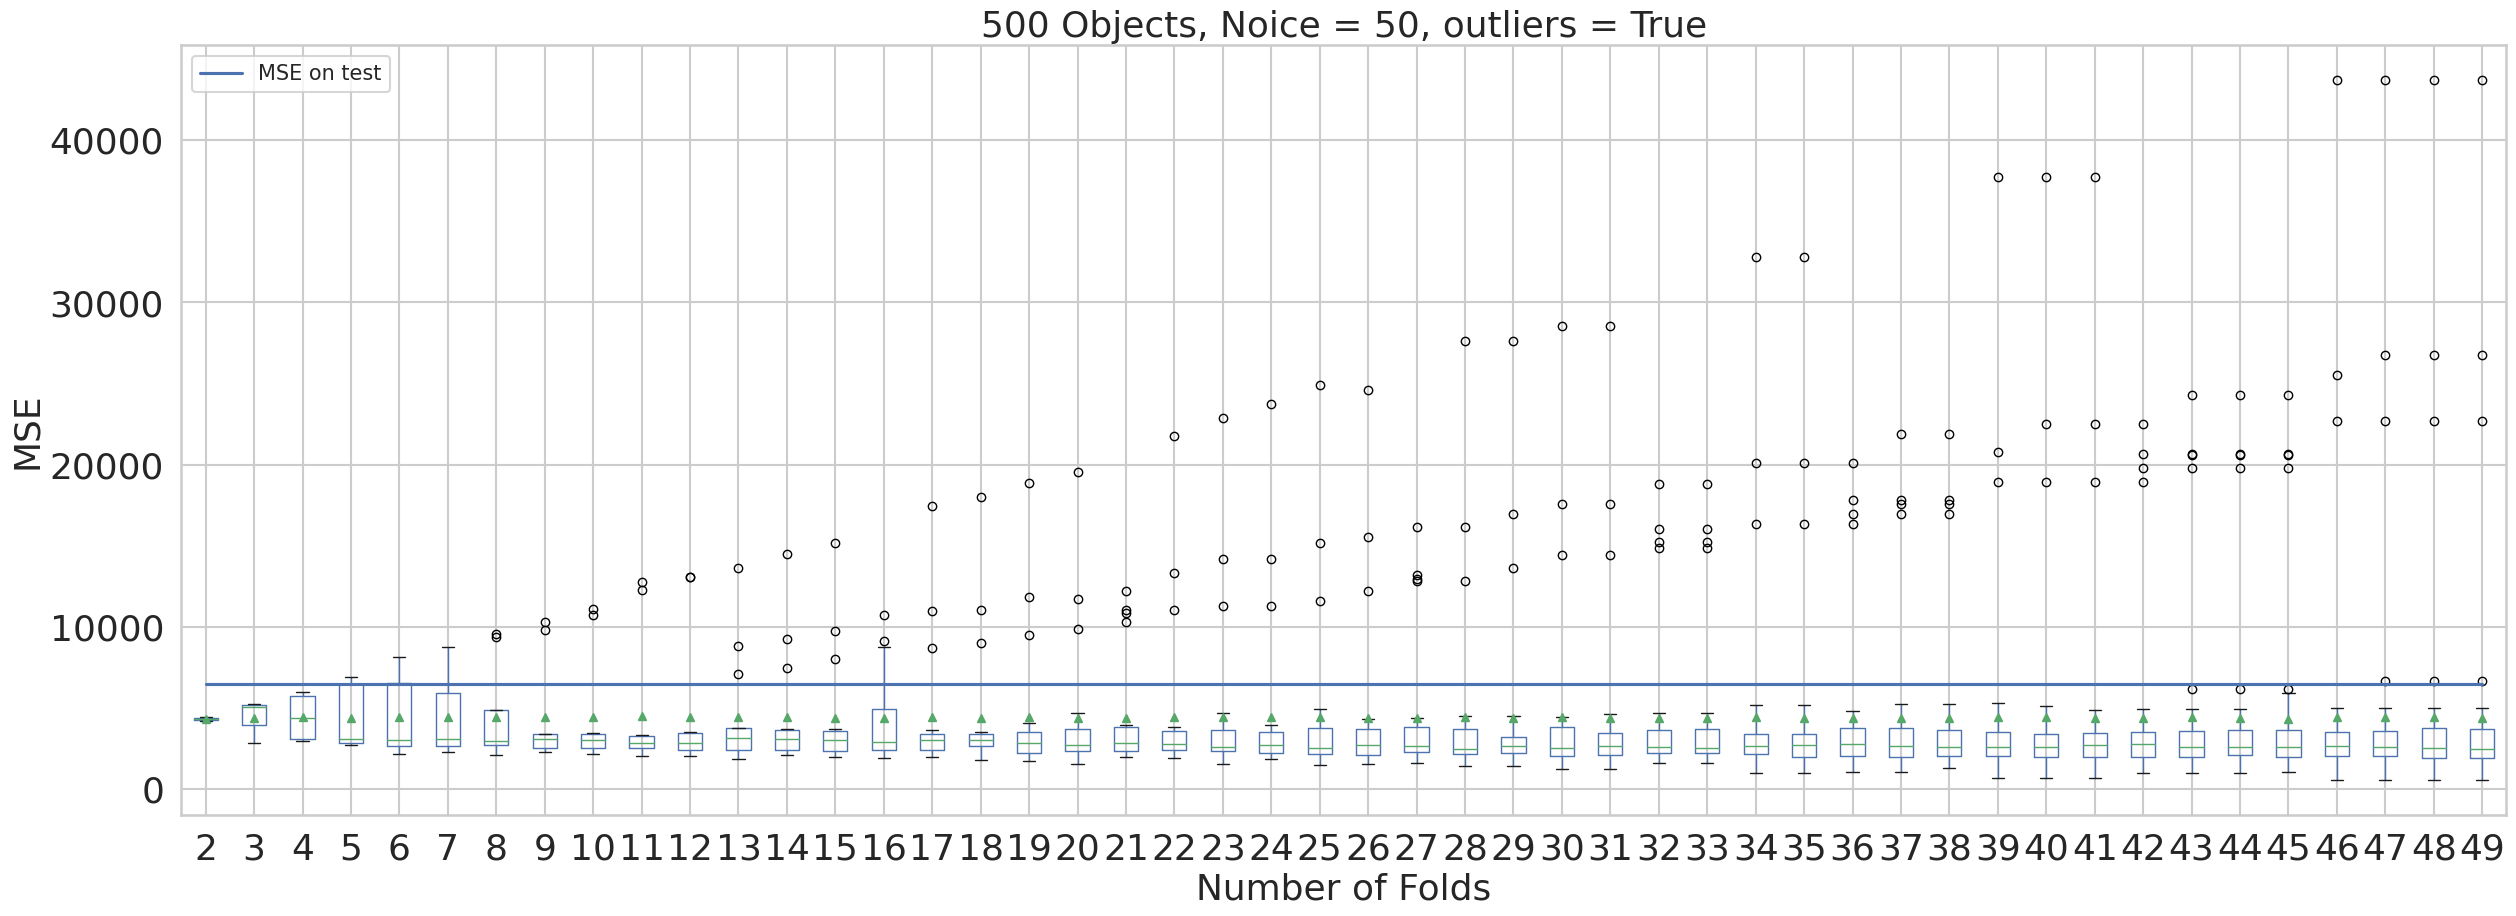

CPU times: user 2.4 s, sys: 19 ms, total: 2.42 s
Wall time: 2.43 s


In [26]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(500, 50, 50, True)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

Видим, что при добавлении выбросов, они преобразуются в выбросы скоров в фолдах, причем достаточно явные. Посмотрим как перераспределилось среднее:


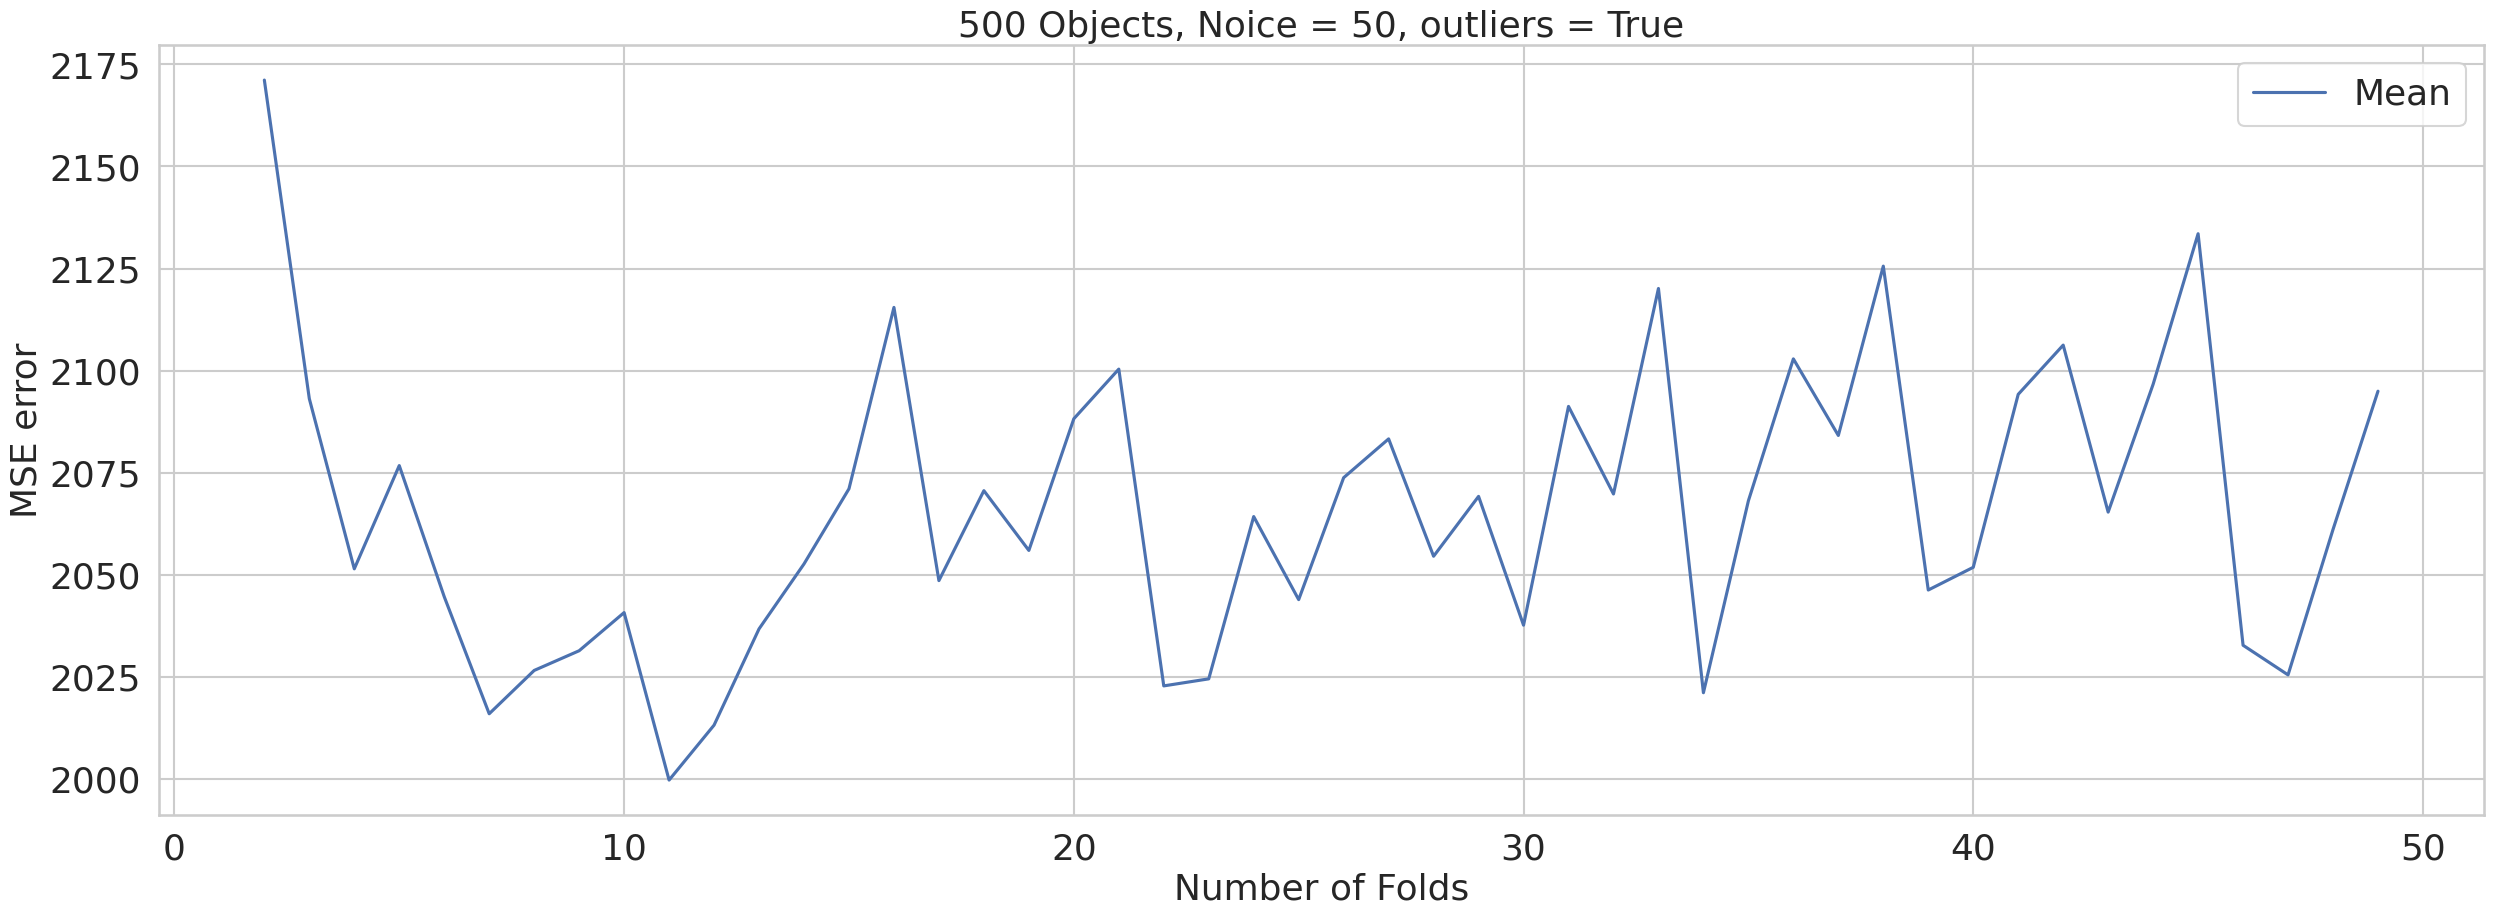

In [27]:

abs(df.mean() - real_MSE).plot(label = "Mean")
plt.title("500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MSE error")
plt.legend()
plt.show()

Колебания MSE всё равно находятся в очень небольших пределах от тестового значения. Добавим больше явных выбросов:

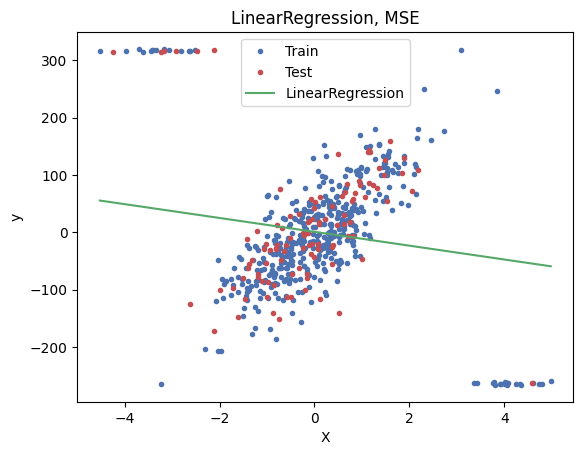

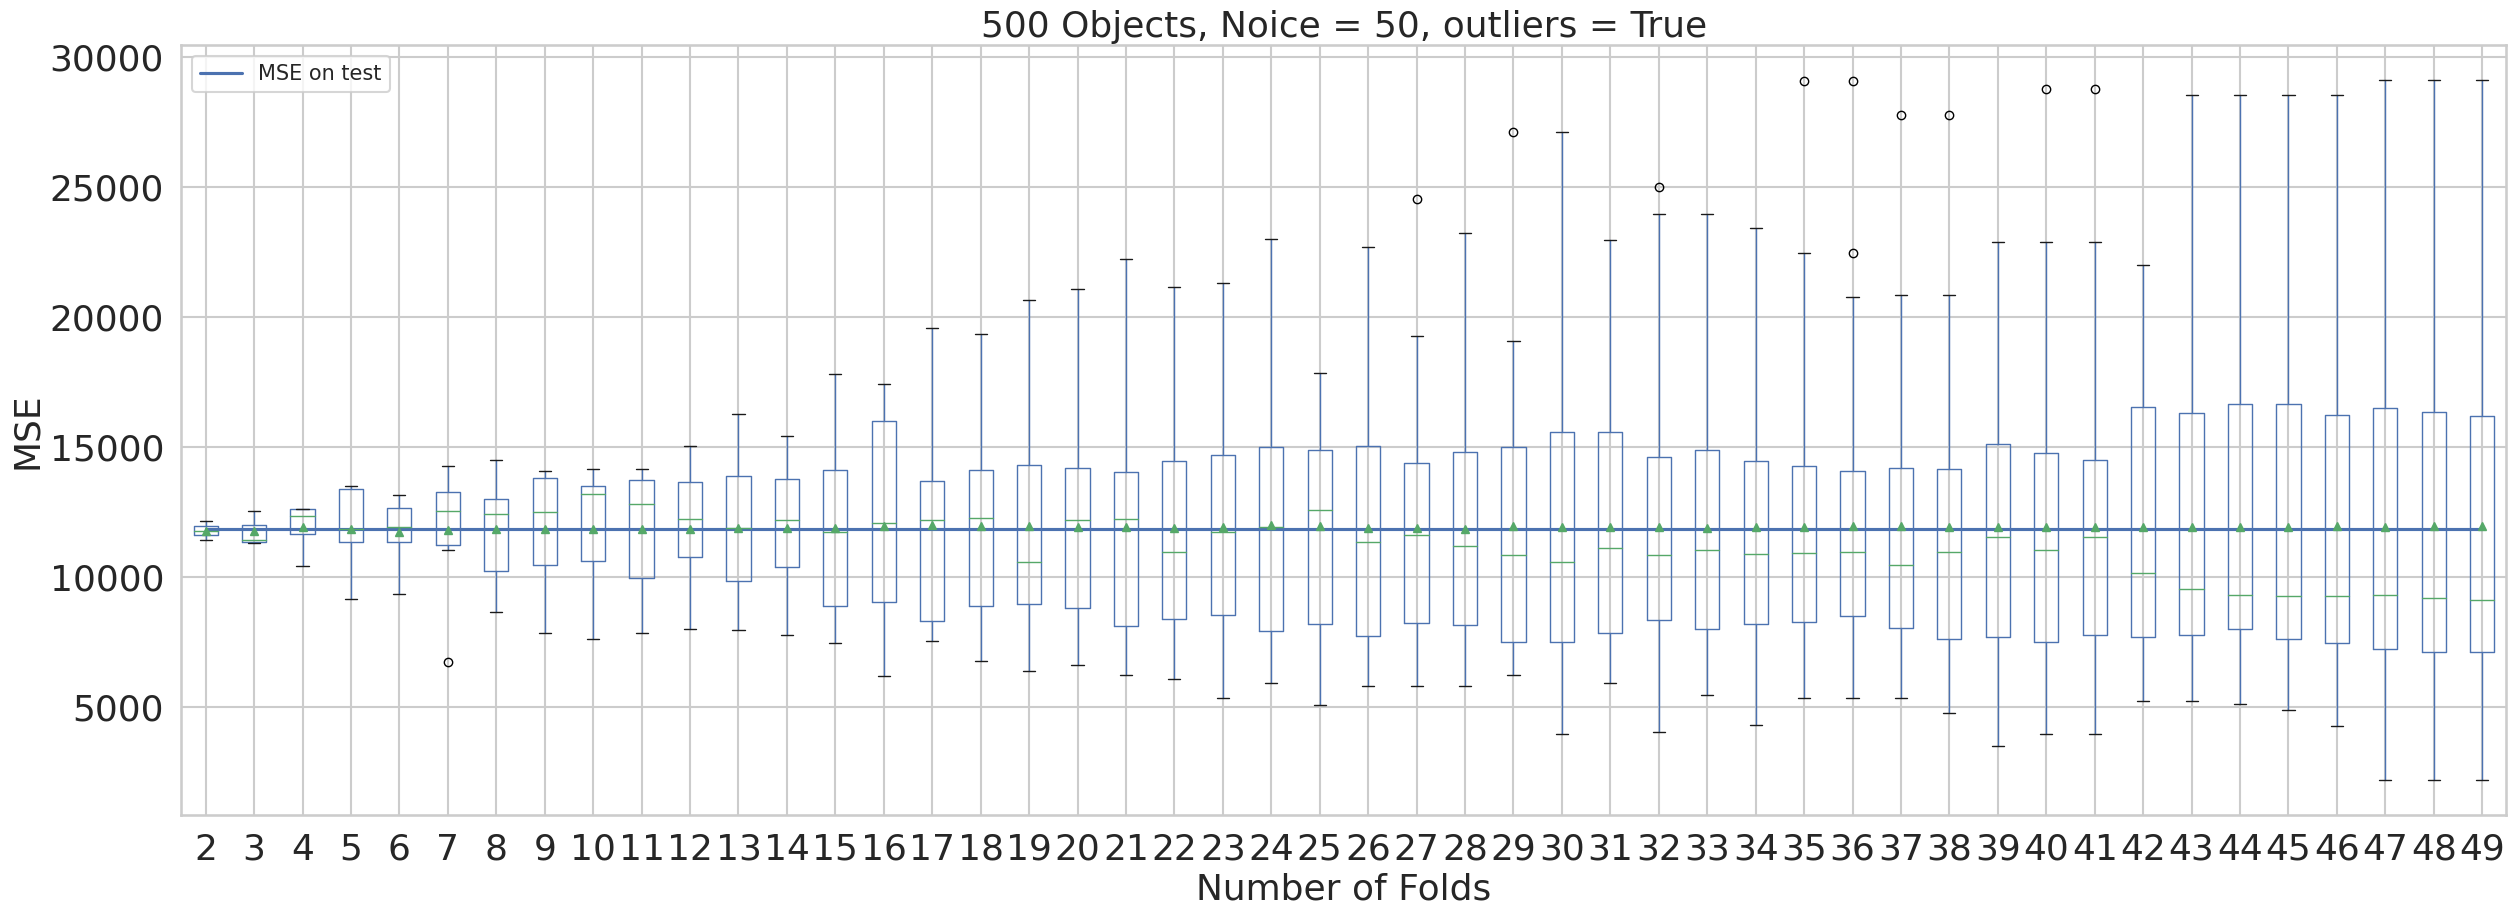

CPU times: user 2.44 s, sys: 22 ms, total: 2.46 s
Wall time: 2.46 s


In [28]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(500, 50, 50, True, 40)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("500 Objects, Noice = 50, outliers = True")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

Видим, что выбросы очень увеличивают разброс, что сильно смещает медиану, но среднее остаётся непоколебимо. Тем не менее, после 10-го фолда разброс начинает сильно увеличиваться, а ошибка не растёт, так что можно сделать вывод, что брать больше 10-ти не стоит. Протестируем гипотезу на более большой выборке с выбросами:


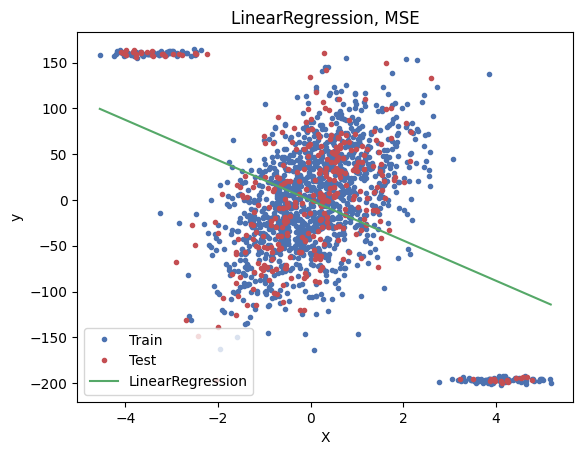

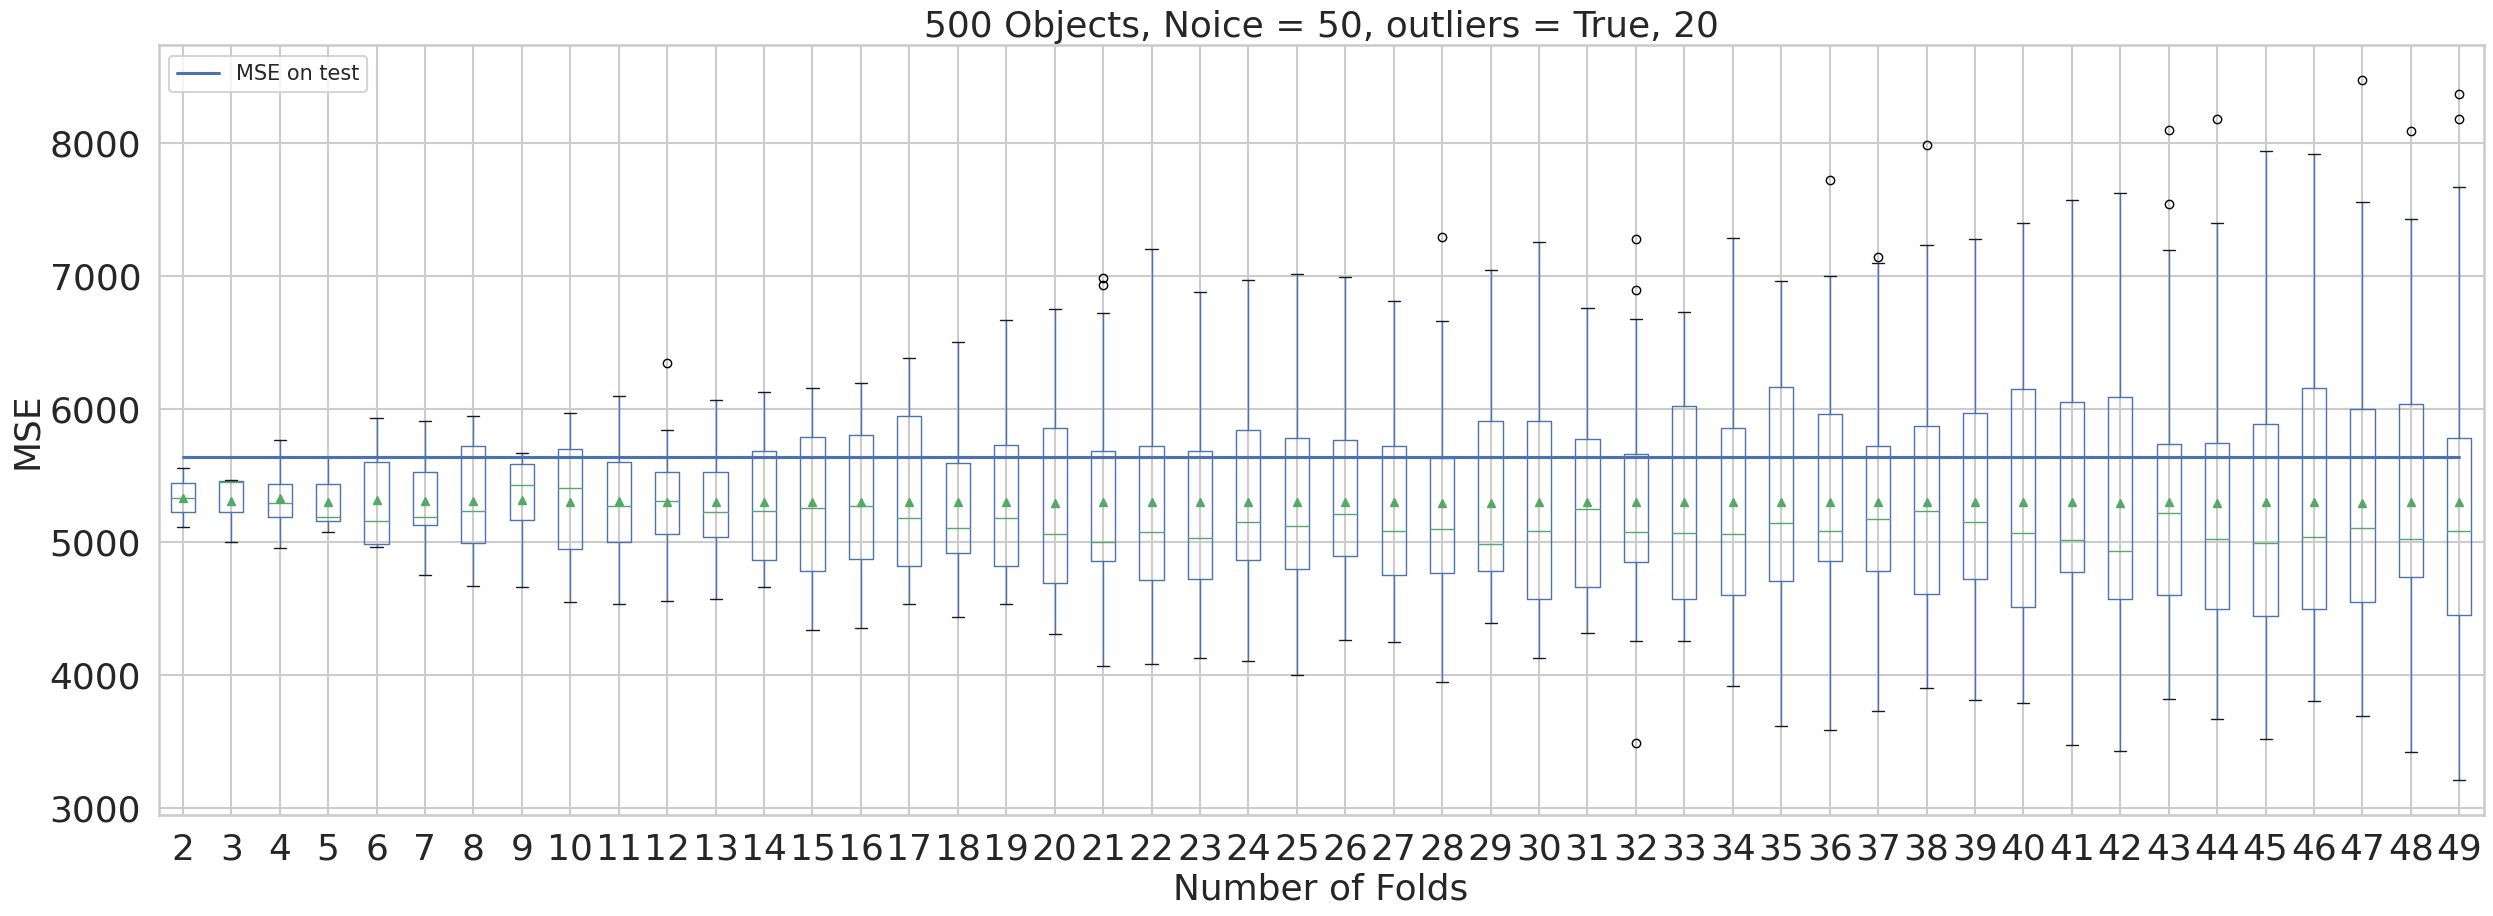

CPU times: user 2.36 s, sys: 13 ms, total: 2.38 s
Wall time: 2.39 s


In [29]:
%%time 
real_MSE, for_plot_mini, dict_folds = make_exp_lr(1500, 50, 50, True, 200)

max_len = max(dict_folds.keys())

for i in dict_folds.keys():
  for j in range(max_len - len(dict_folds[i])):
    dict_folds[i].append(np.nan)


df = pd.DataFrame(dict_folds)

dic = df.plot.box(return_type = 'dict', showmeans=True)
x_coordinates = [1, len(dict_folds)]
y_coordinates = [real_MSE, real_MSE]
plt.plot(x_coordinates, y_coordinates, label="MSE on test")
plt.legend(fontsize=15)
plt.title("500 Objects, Noice = 50, outliers = True, 20")
plt.xlabel("Number of Folds")
plt.ylabel("MSE")
plt.show()

И на такой выборке оптимум достигается на <= 10 фолдов

# Выводы
Протестировалось применение валидации на K-Fold для двух видов регрессии - с функцией ошибки MAE и MSE.   
Общий вывод един - вне заивисимости от числа объектов в выборке, уровня шума и числа выбросов, во всех описанных выше примерах оптимальное значение на валидации находилось в <= 10 фолдах. Дальше уже постепенно начинала расти дисперсия, причём, что логично, чем больше было явных выбросов, тем больше и быстрее она росла. 
